In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN,AgglomerativeClustering
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm



plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [110]:
data = pd.read_csv("data_prespective.csv")

In [111]:
data.set_index("ID", inplace=True)

In [112]:
data.head()

Age  UseByTime  AthleticsActivities  WaterActivities  \
ID                                                                 
10000  3.083333          0                  0.0              0.0   
10001  0.500000          0                  0.0              0.0   
10002  0.000000          0                  0.0              0.0   
10003 -1.166667          0                  0.0              0.0   
10004  1.000000          0                  0.0              0.0   

       FitnessActivities  TeamActivities  RacketActivities  CombatActivities  \
ID                                                                             
10000                1.0             0.0               0.0               0.0   
10001                0.0             0.0               0.0               0.0   
10002                1.0             0.0               0.0               0.0   
10003                0.0             1.0               0.0               0.0   
10004                1.0             0.0               0.0               0.0   

       SpecialActivities  OtherActivities  Dropout  Active_Period  \
ID                                                                  
10000                0.0              0.0        0       0.000000   
10001                1.0              0.0        1       0.989071   
10002                0.0              0.0        1      -0.016393   
10003                0.0              0.0        1       0.989071   
10004                0.0              0.0        1      -0.016393   

       Contract_Duration  PercentageOfVisits  MonthlyValue  \
ID                                                           
10000          -0.490868                1.15      3.017065   
10001           0.285388               -0.20      0.607509   
10002          -0.554795                0.50      0.493905   
10003          -0.257991                0.35      0.176012   
10004           1.152968               -0.50     -0.611409   

       PercentageOfClasses  Freq_Visits_Day  Visits_ActivePeriod  \
ID                                                                 
10000             1.866571         0.763419            -0.201465   
10001             0.104392        -0.204771            -0.501832   
10002             0.000000         1.208748             0.619048   
10003             0.239981         0.463221            -0.300366   
10004             0.000000        -0.255467            -0.600733   

       Gender_Female  
ID                    
10000              1  
10001              1  
10002              0  
10003              0  
10004              0

In [113]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod', 'MonthlyValue','Active_Period']

In [114]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']
compare = ['Dropout', 'Gender_Female','UseByTime']

#### Necessary Functions

In [115]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

In [116]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

## DBSCAN FOR OUTLIER REMOVAL:

 Since we know that our data is highly skewed and contains outliers not removed, we apply a DBSCAN to try to detect the remaining outliers.

 We need to define the parameters of our model ( **ε** and **min_samples**):
 
 -  **min_samples**  is, on a first approach, considered **2 x dim** where dim is the dimension of our metric features;
 - **ε** can be found by ploting a **k-distance graph** (distance to the kth (k = min_samples - 1) nearest neighbor ordered from the largest to the smallest value). The **elbow** of this graph is considered a good value for ε.

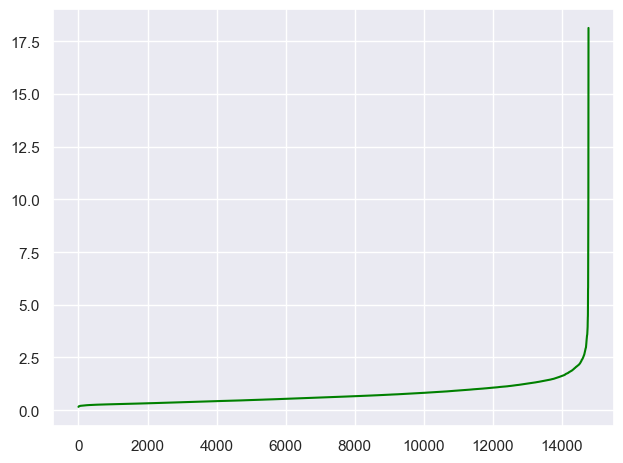

In [117]:
neigh = NearestNeighbors(n_neighbors = (2 * len(metric_features)) - 1)
neigh.fit(data[metric_features])
distances, _ = neigh.kneighbors(data[metric_features])
distances = np.sort(distances[:, -1])
#plt.yticks(np.arange(1,22,0.5))
plt.plot(distances, color = 'green')
plt.show()

An **ε** of 2.25 is selected as the optimal value.

In [118]:
dbscan = DBSCAN(eps=2.25, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

Counter(dbscan_labels)

Counter({0: 14687, -1: 86})

In [119]:
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [120]:
data.shape

(14687, 19)

In [121]:
demographic_perspective = ['Age', 'Active_Period', 'MonthlyValue', 'Contract_Duration']
df_demographic = data[demographic_perspective]

In [122]:
frequency_perspective = [ 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']

df_frequency = data[frequency_perspective]

### K-Means + Hierarchial clustering

### Frequency Perspective

In [124]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [96]:
# Obtaining the R² scores for each cluster solution on frequency variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_frequency, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
    df_demographic, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.347787  0.057110  0.083328  0.000691  0.201644
3  0.564932  0.238859  0.083587  0.002181  0.368119
4  0.648661  0.427350  0.096338  0.002437  0.469989
5  0.718441  0.434889  0.309086  0.002584  0.539211
6  0.755161  0.490251  0.309959  0.003363  0.590800
7  0.786368  0.501684  0.315849  0.003376  0.630527
8  0.805068  0.507324  0.317968  0.007190  0.658775
9  0.822899  0.548836  0.356714  0.007453  0.679054

In [97]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_frequency[frequency_perspective])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', sty

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARA.TTF', name='Garamond', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-LIGHT.TTF', name='Dubai', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='norm

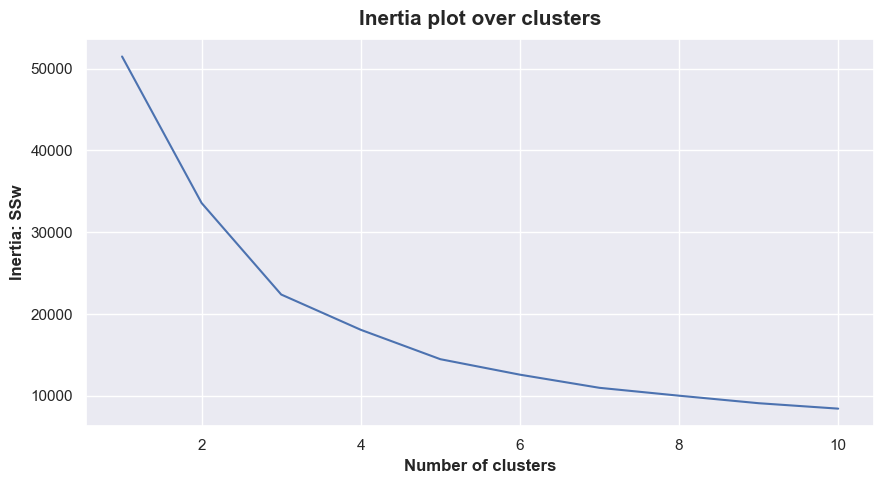

In [98]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.438281834635259
For n_clusters = 3, the average silhouette_score is : 0.4718023451171246
For n_clusters = 4, the average silhouette_score is : 0.4165320646278527
For n_clusters = 5, the average silhouette_score is : 0.44389951967182467
For n_clusters = 6, the average silhouette_score is : 0.4080267204698751
For n_clusters = 7, the average silhouette_score is : 0.39787089969425427
For n_clusters = 8, the average silhouette_score is : 0.3942831662879862
For n_clusters = 9, the average silhouette_score is : 0.3741484903038245
For n_clusters = 10, the average silhouette_score is : 0.3620258058584242


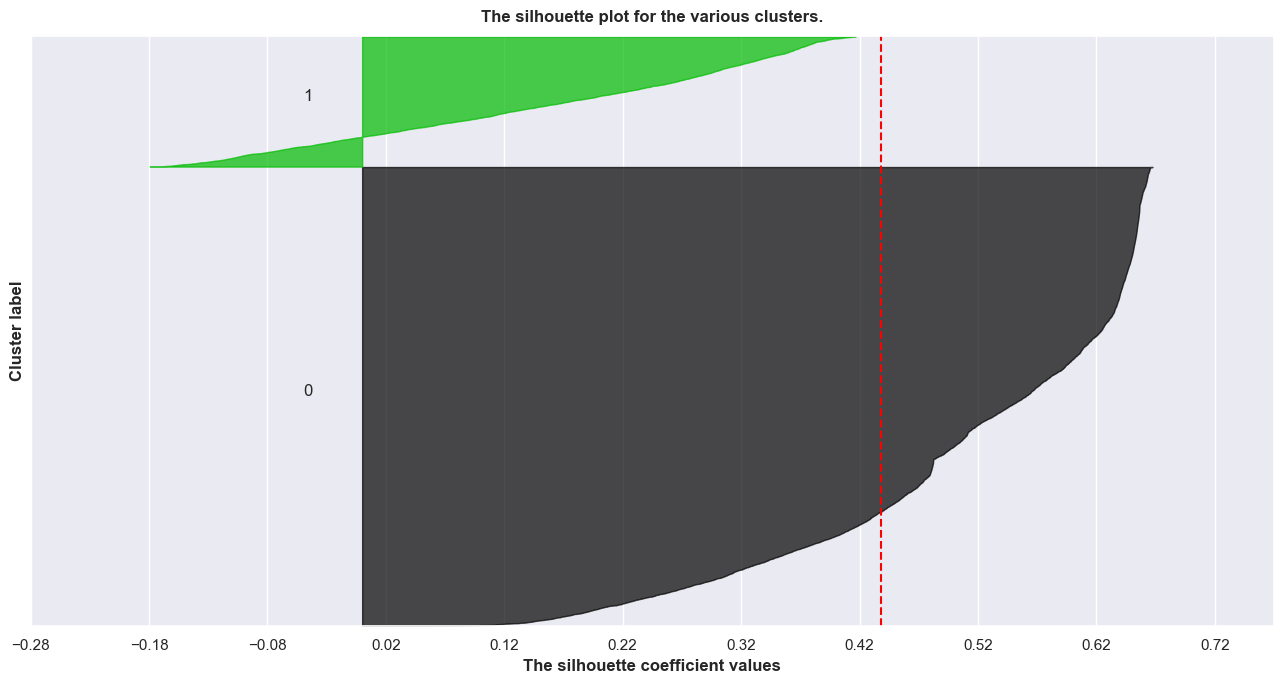

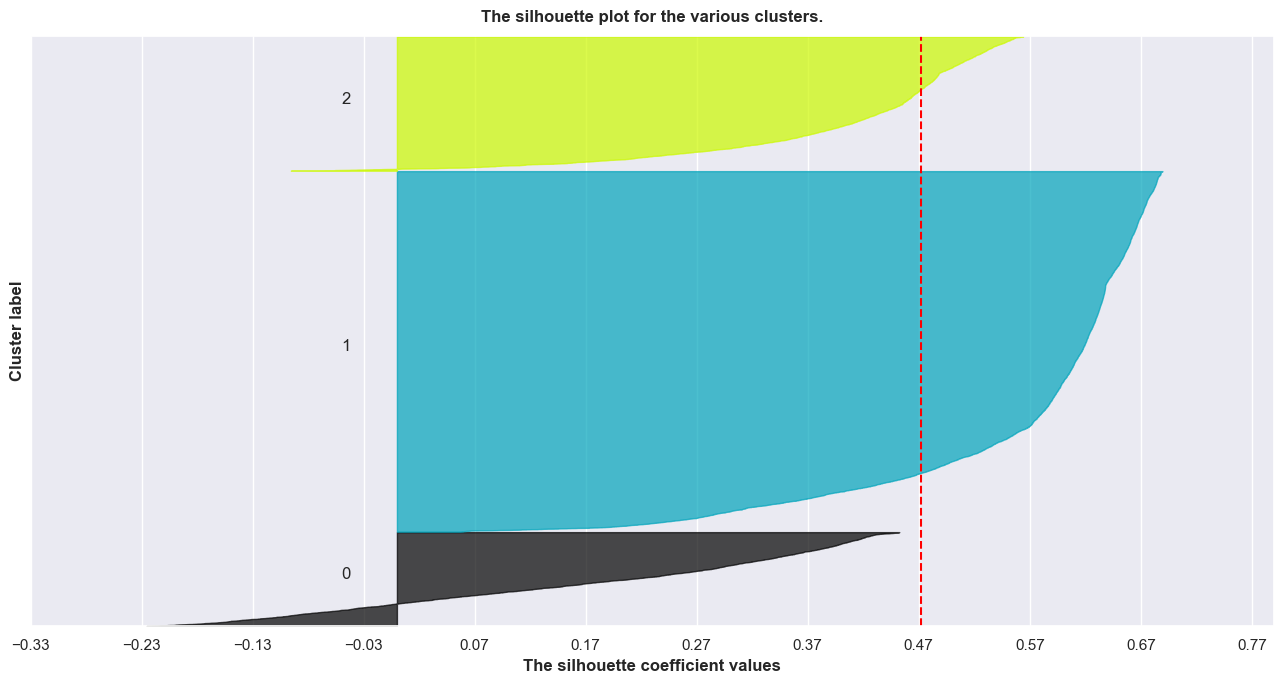

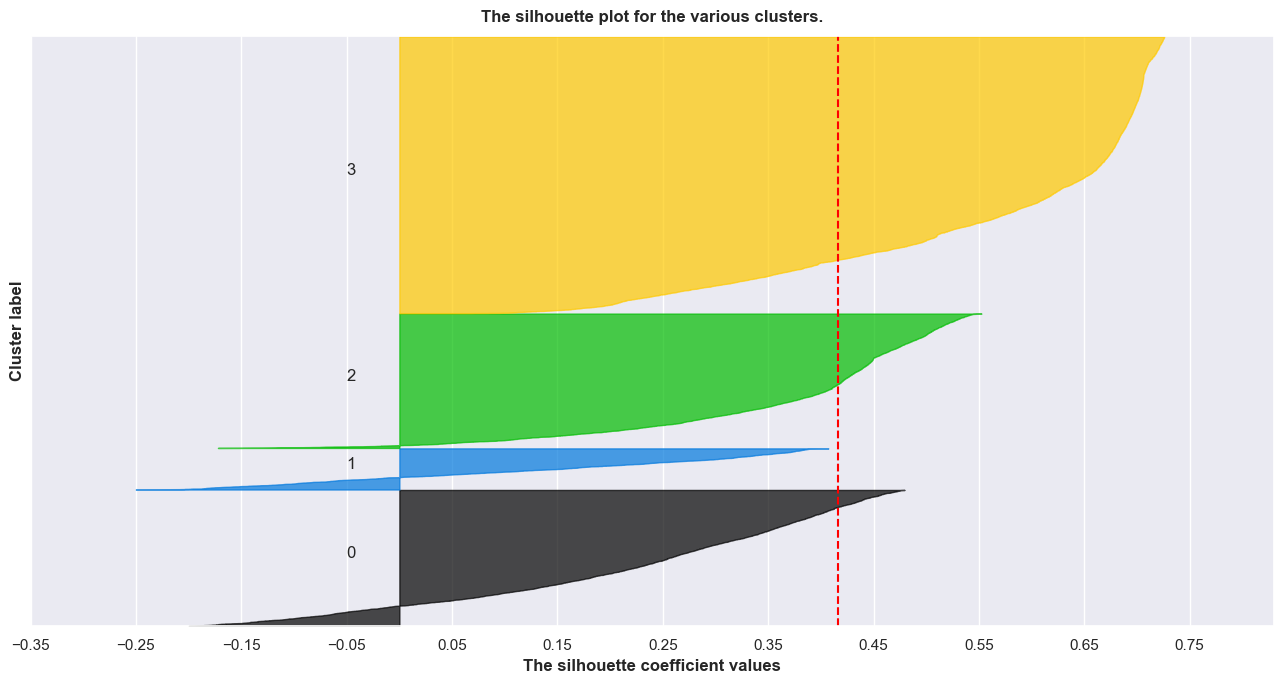

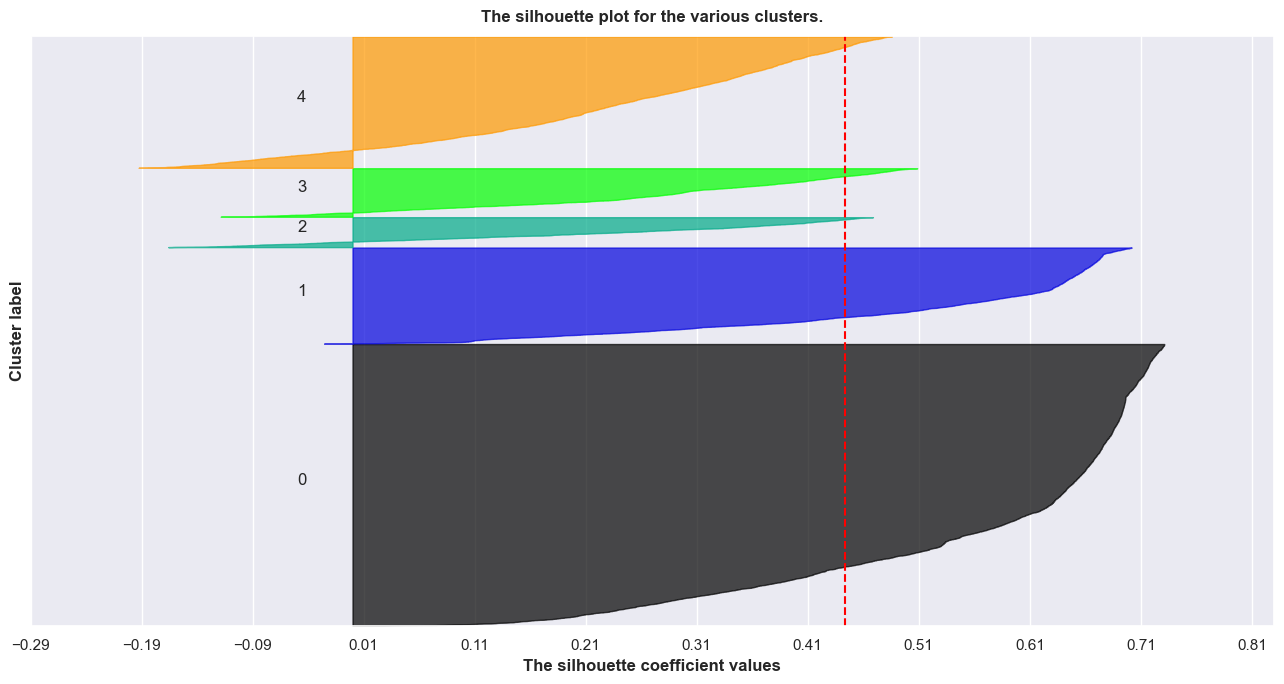

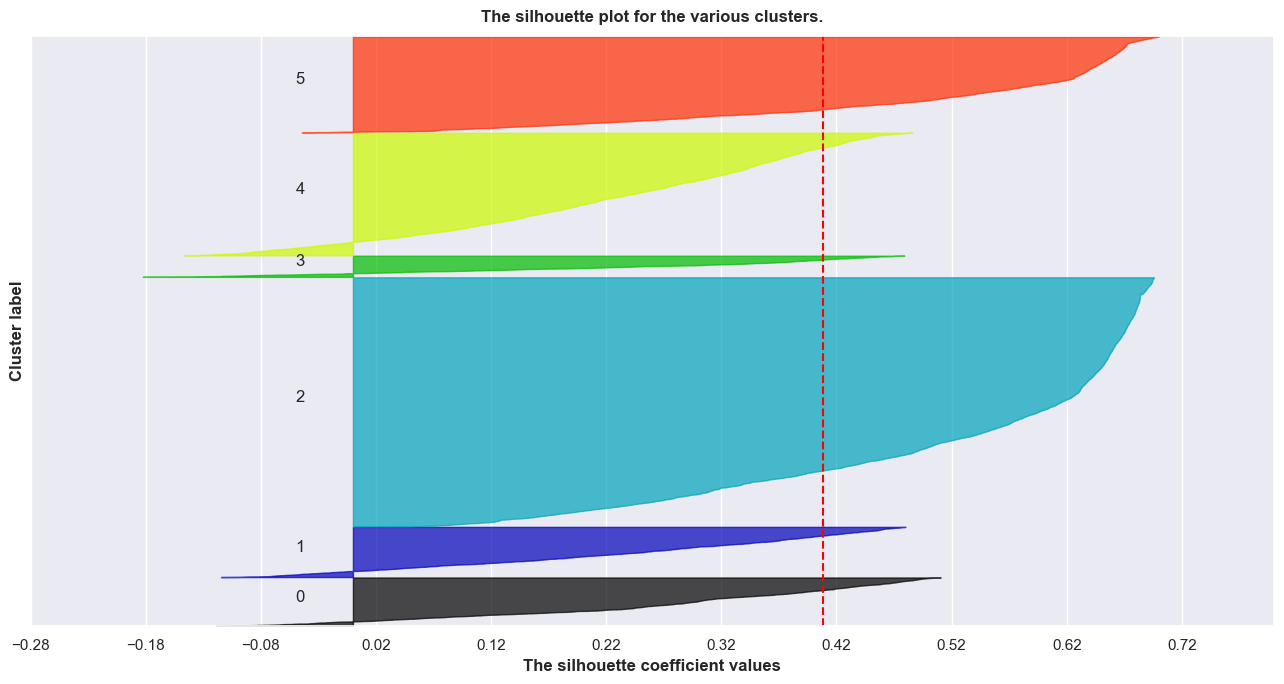

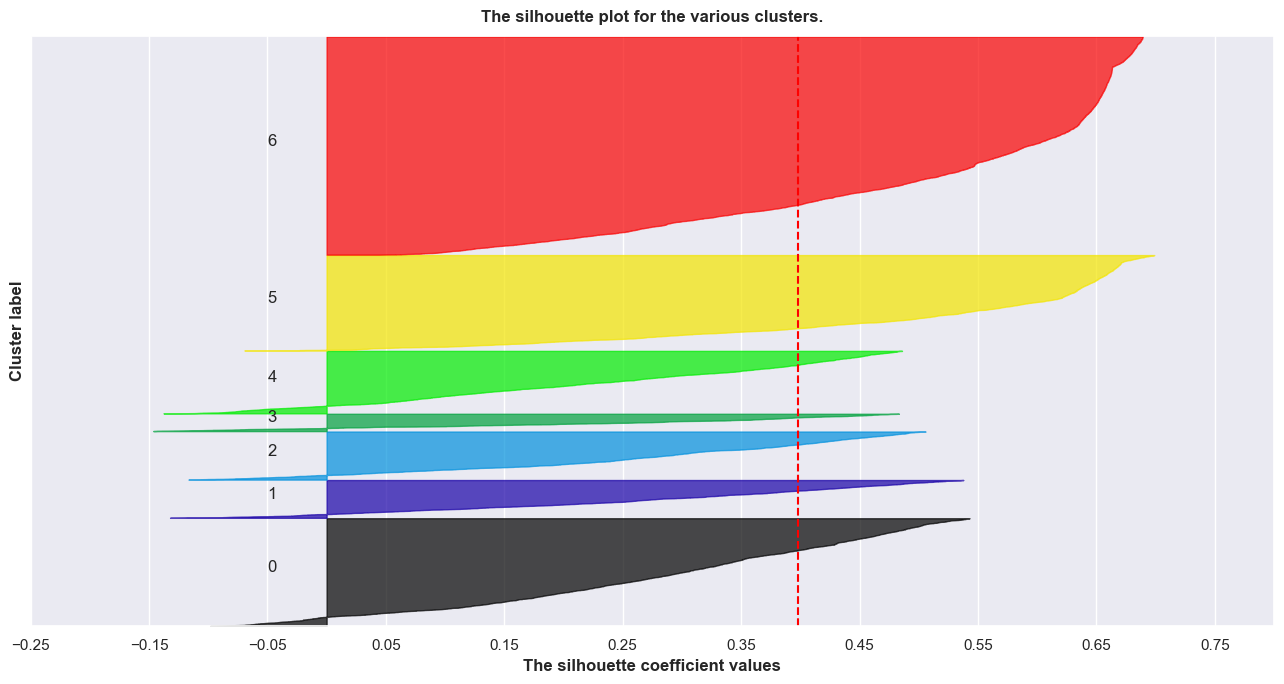

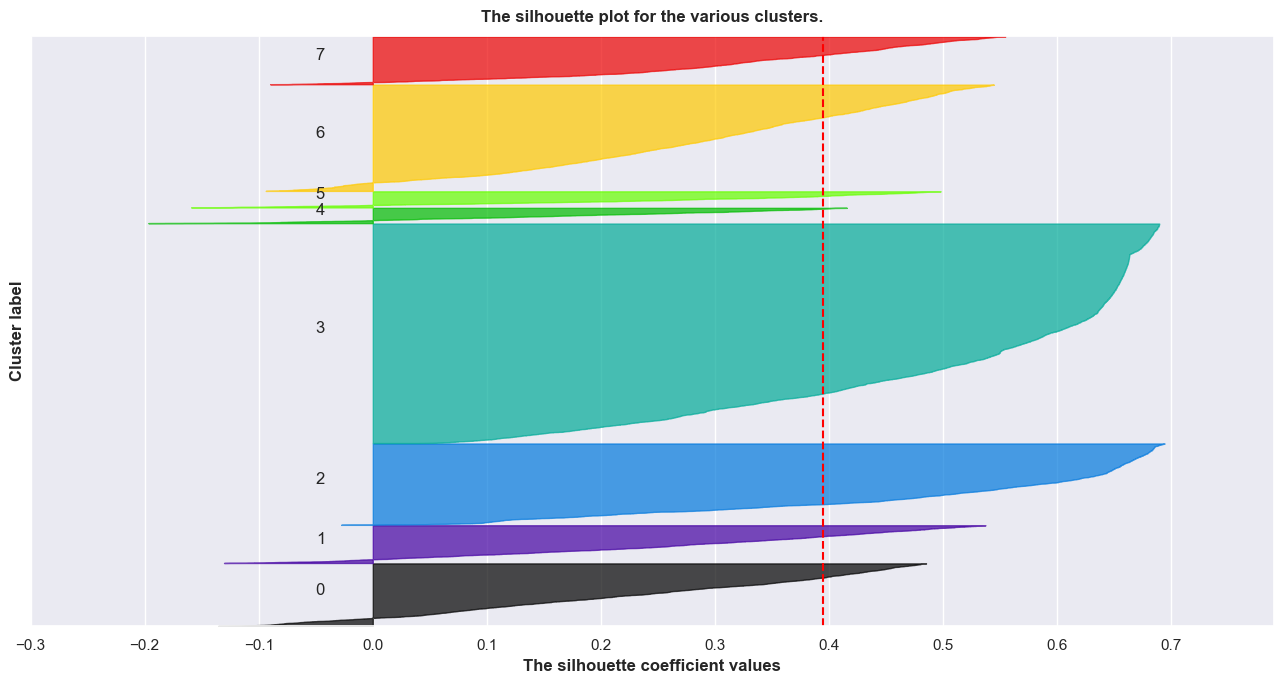

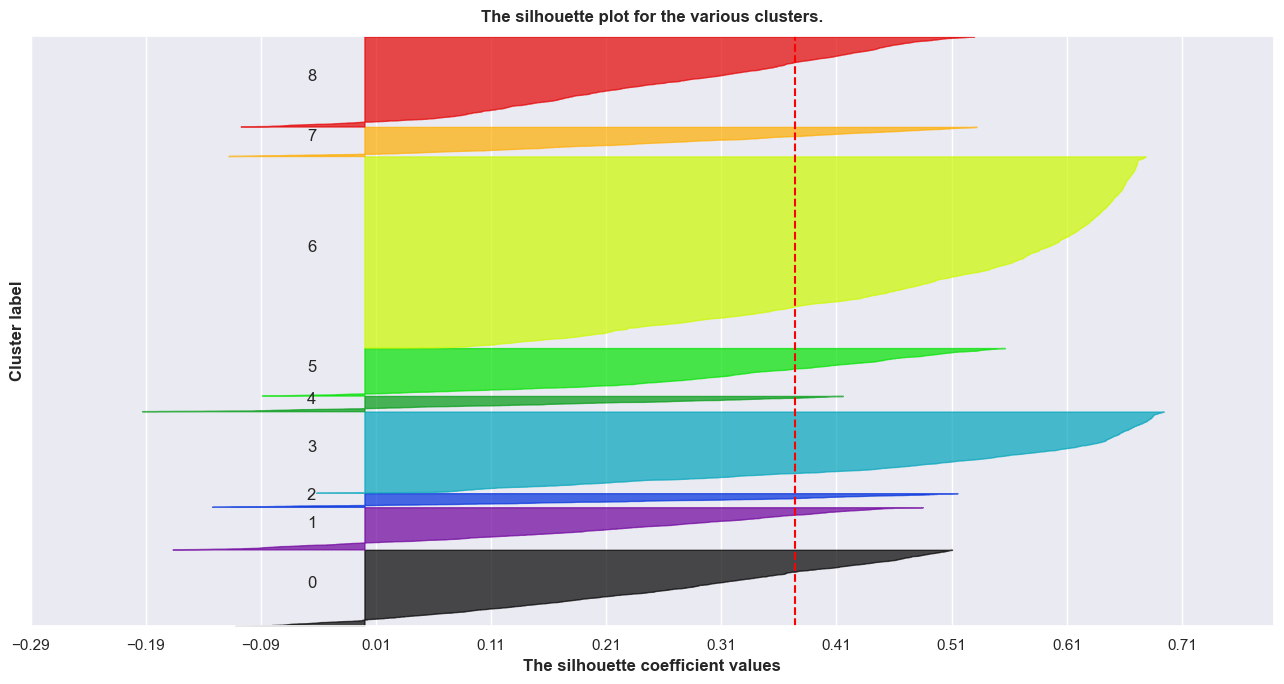

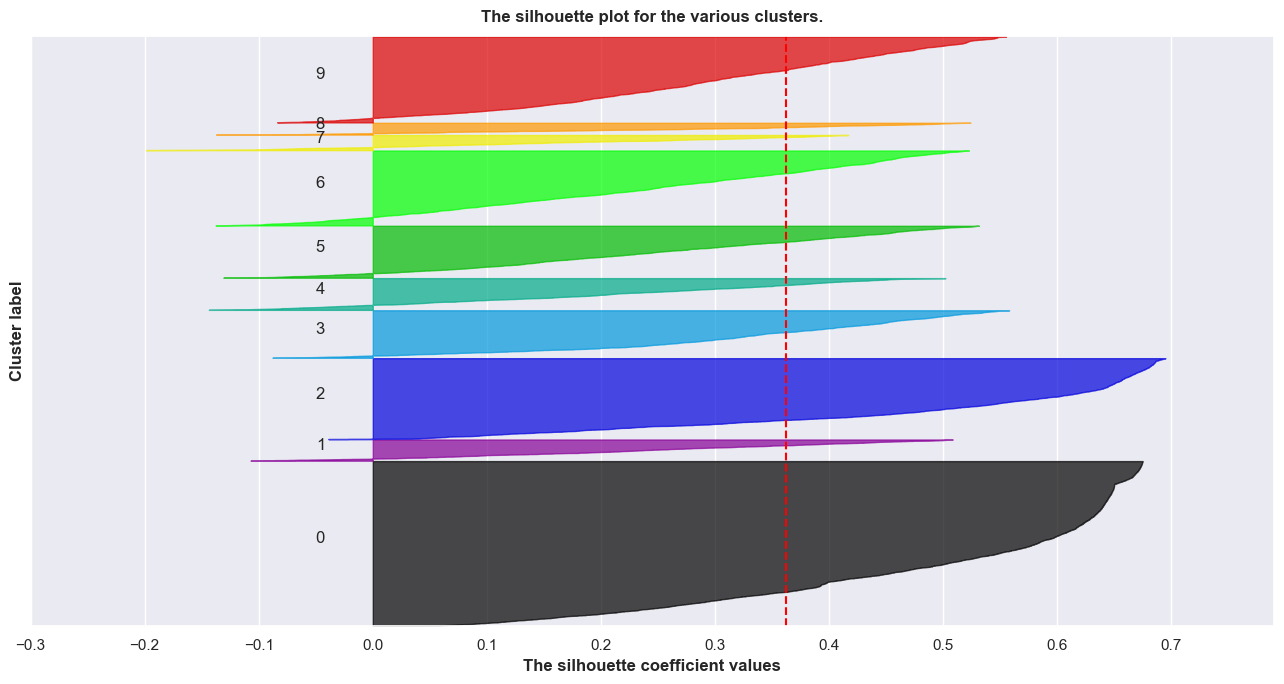

In [126]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_frequency[frequency_perspective])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_frequency[frequency_perspective], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_frequency[frequency_perspective], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_frequency[frequency_perspective]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

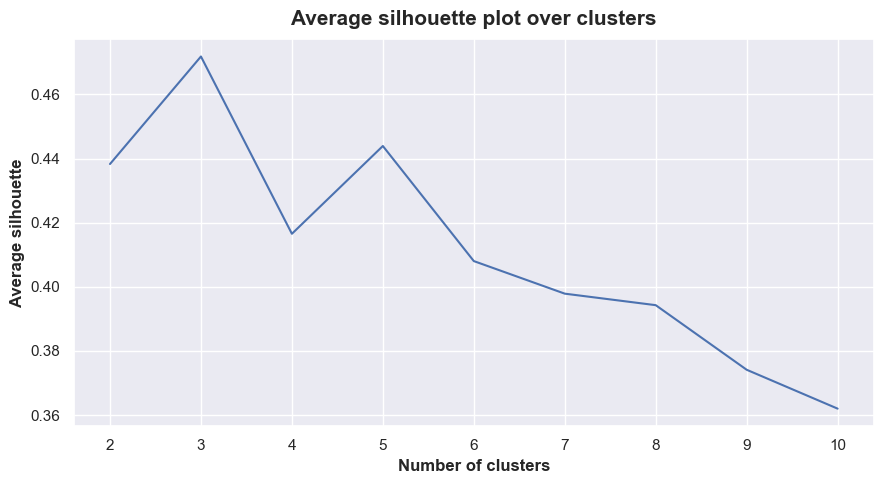

In [127]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

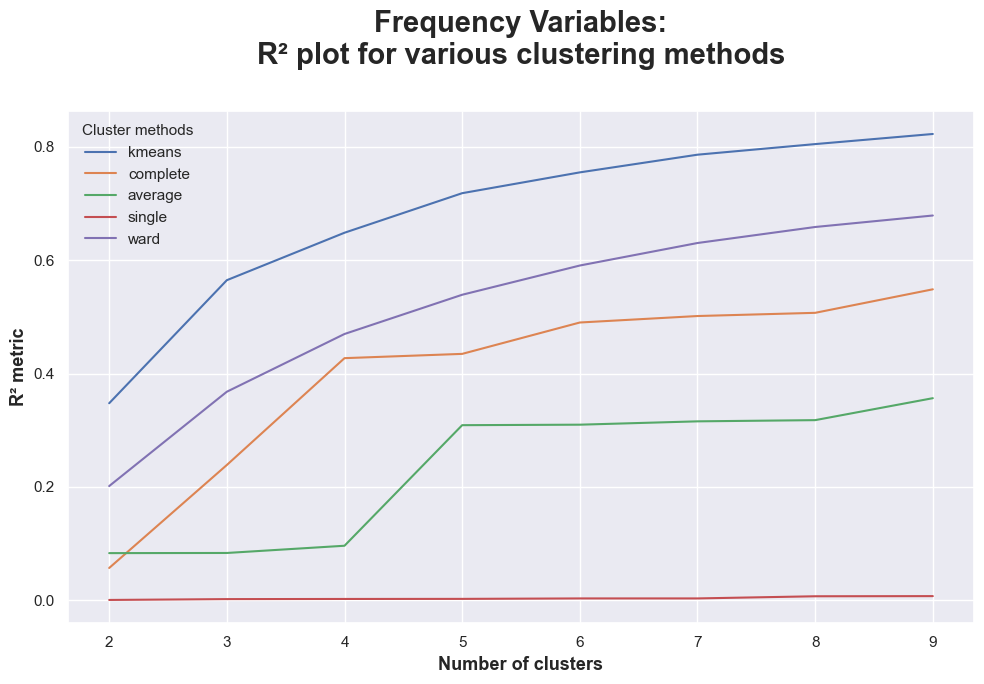

In [128]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Frequency Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Demographic Perspective

In [ ]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_demographic[demographic_perspective])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', 

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ArialNova-Light.ttf', name='Arial Nova', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GeorgiaPro-CondLightItalic.ttf', name='Georgia Pro', style='italic', variant='normal', weight=300, stretch='condensed', size='scalable')) = 11.344999999999999
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RockwellNovaCond

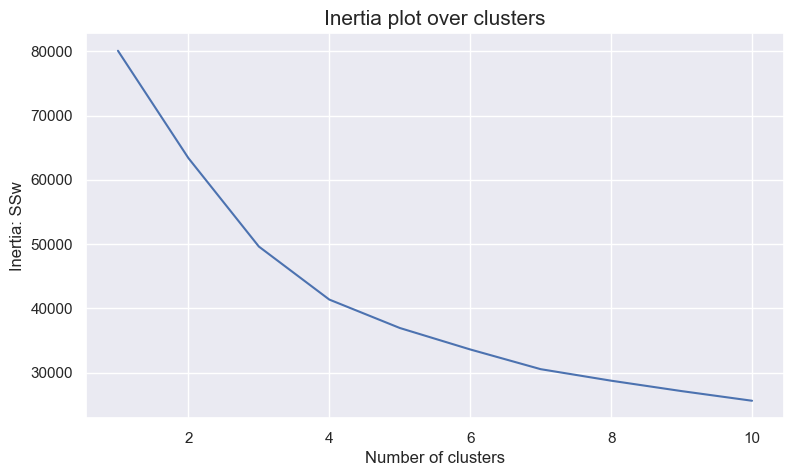

In [ ]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.3531311066770717
For n_clusters = 3, the average silhouette_score is : 0.32531417482476543
For n_clusters = 4, the average silhouette_score is : 0.2895190709196134
For n_clusters = 5, the average silhouette_score is : 0.30278462053499244
For n_clusters = 6, the average silhouette_score is : 0.2582521295592398
For n_clusters = 7, the average silhouette_score is : 0.2879857007631874
For n_clusters = 8, the average silhouette_score is : 0.29386473428892235
For n_clusters = 9, the average silhouette_score is : 0.2963629476261627
For n_clusters = 10, the average silhouette_score is : 0.2990175353120047


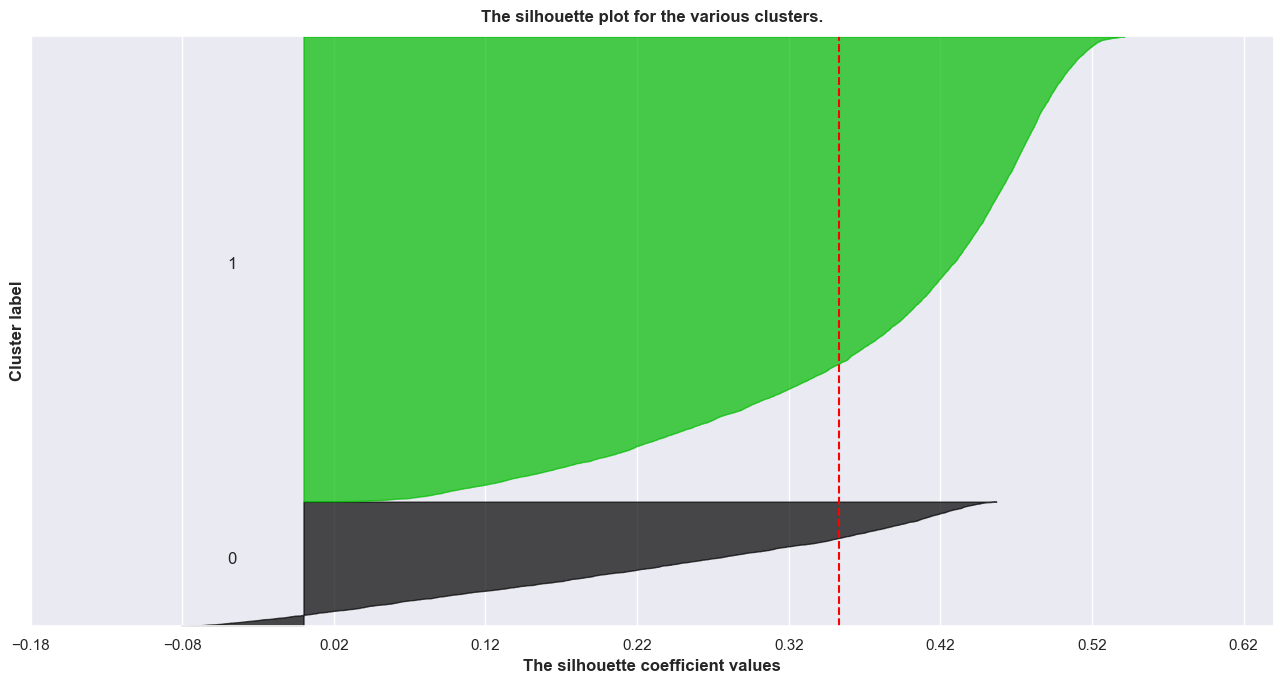

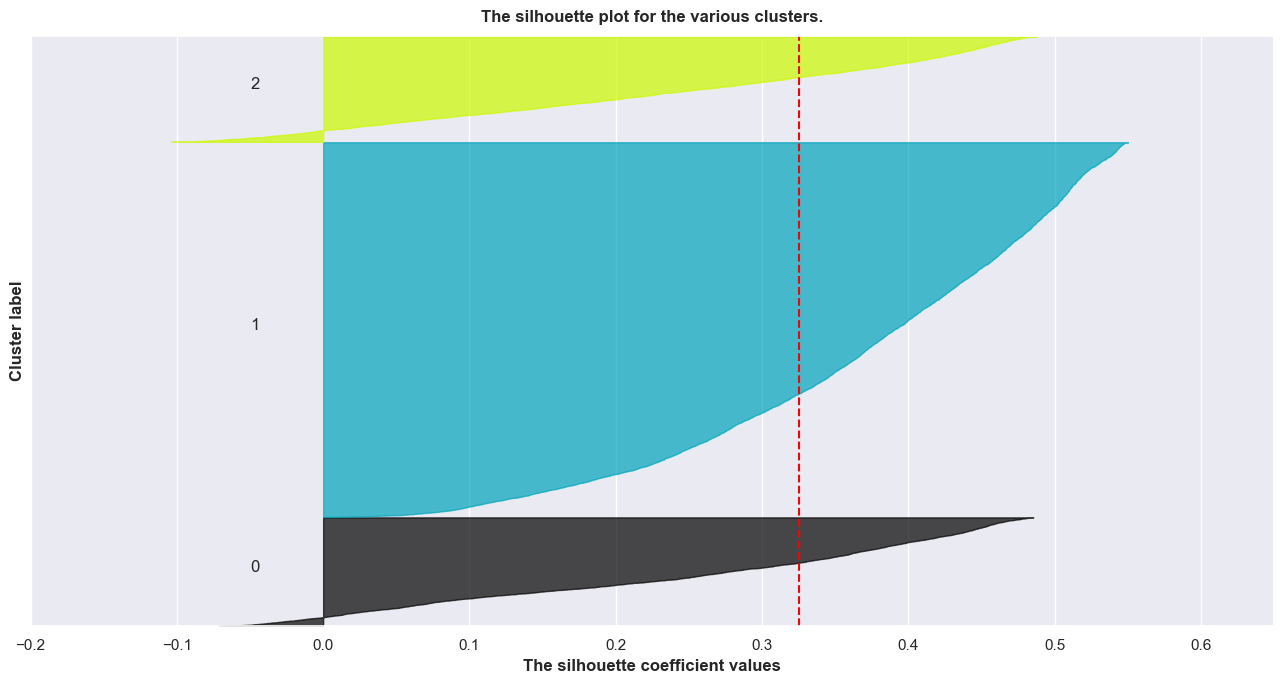

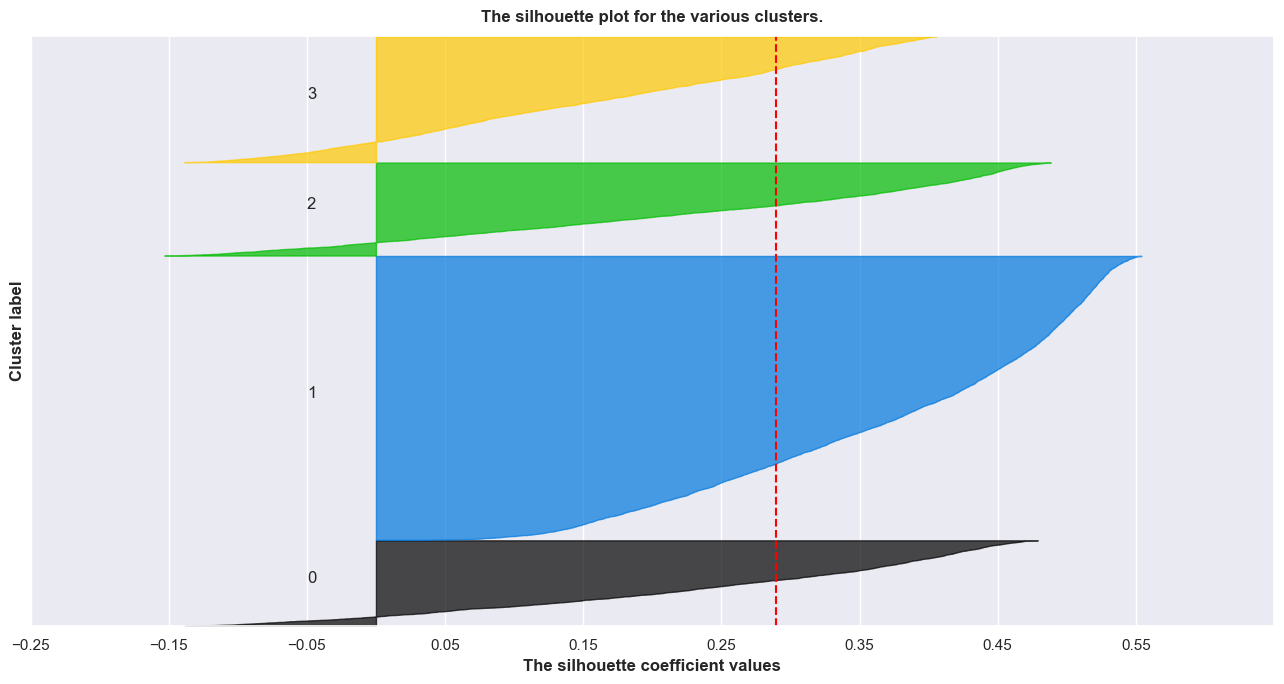

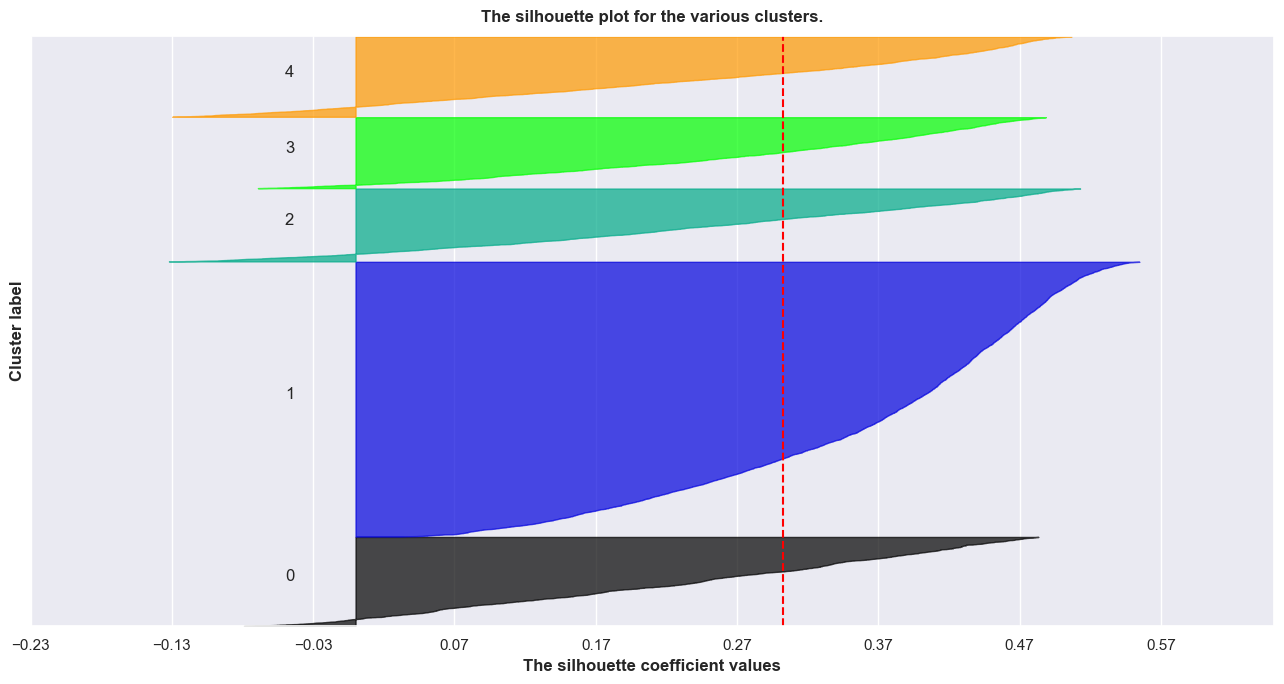

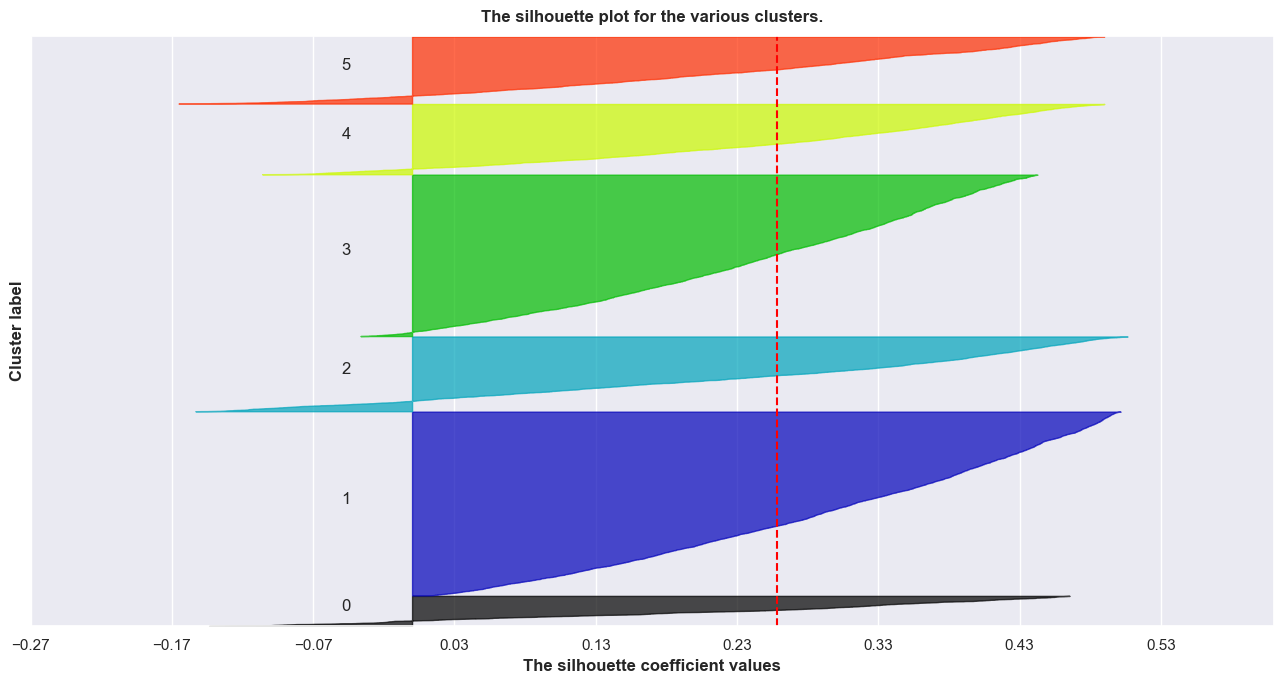

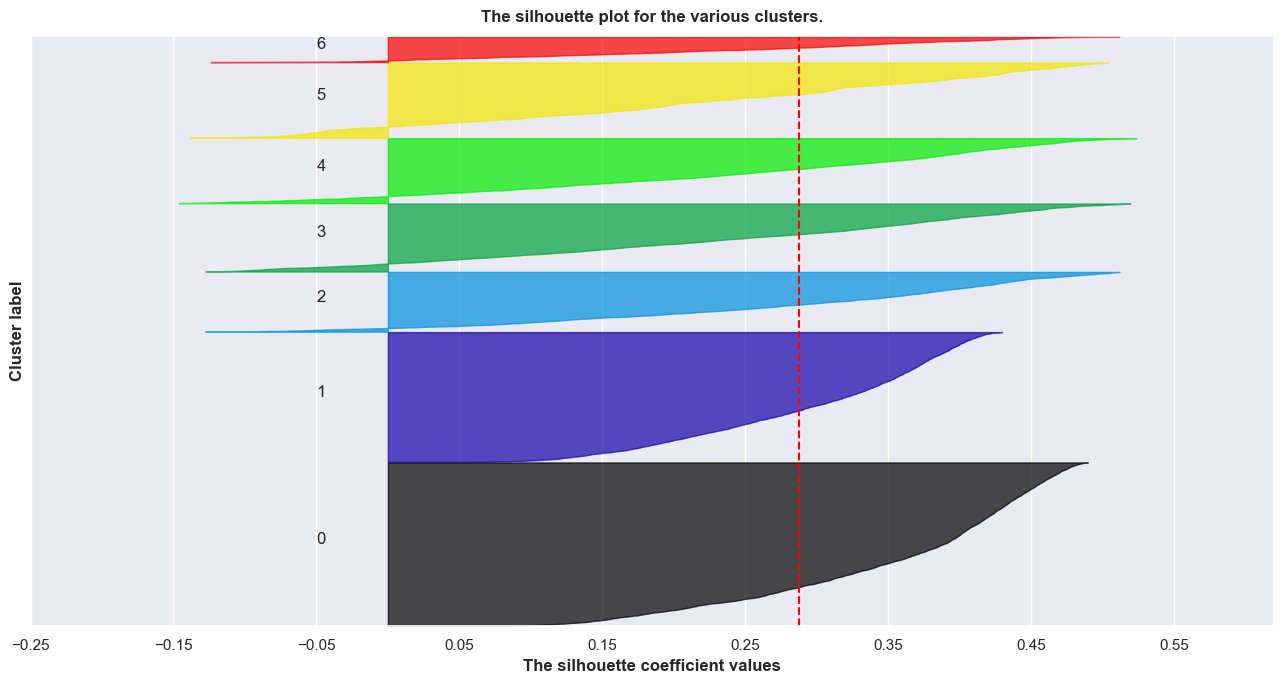

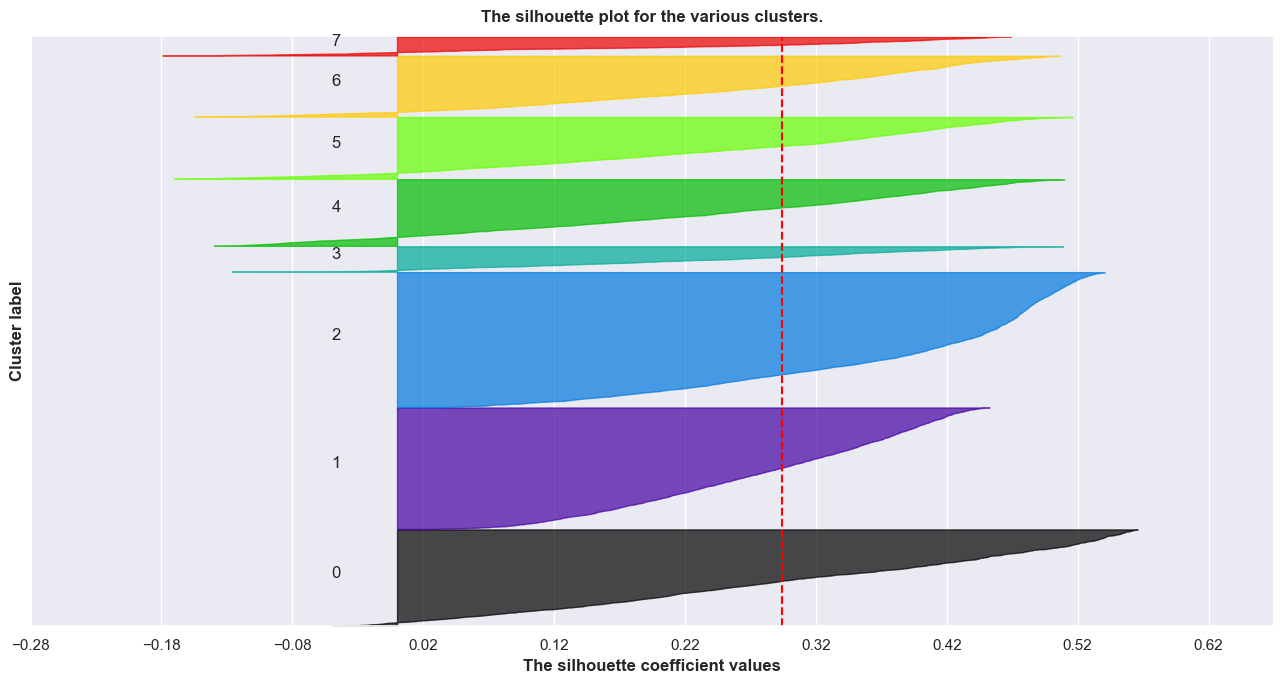

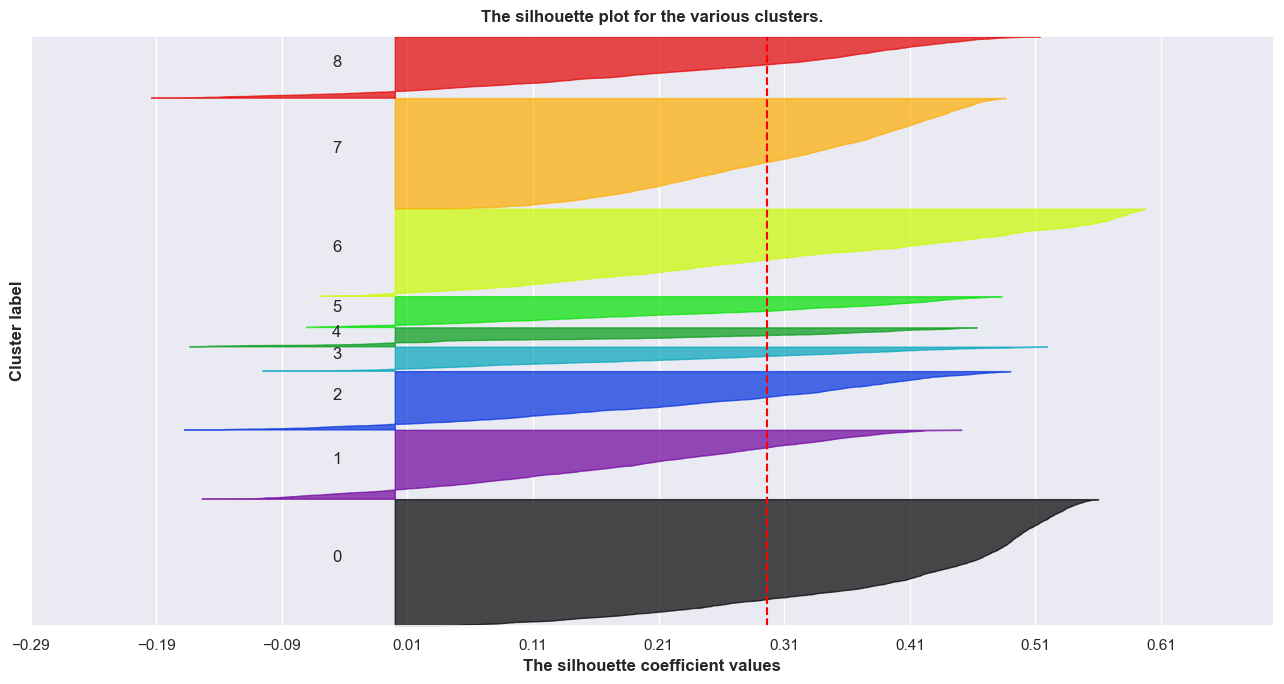

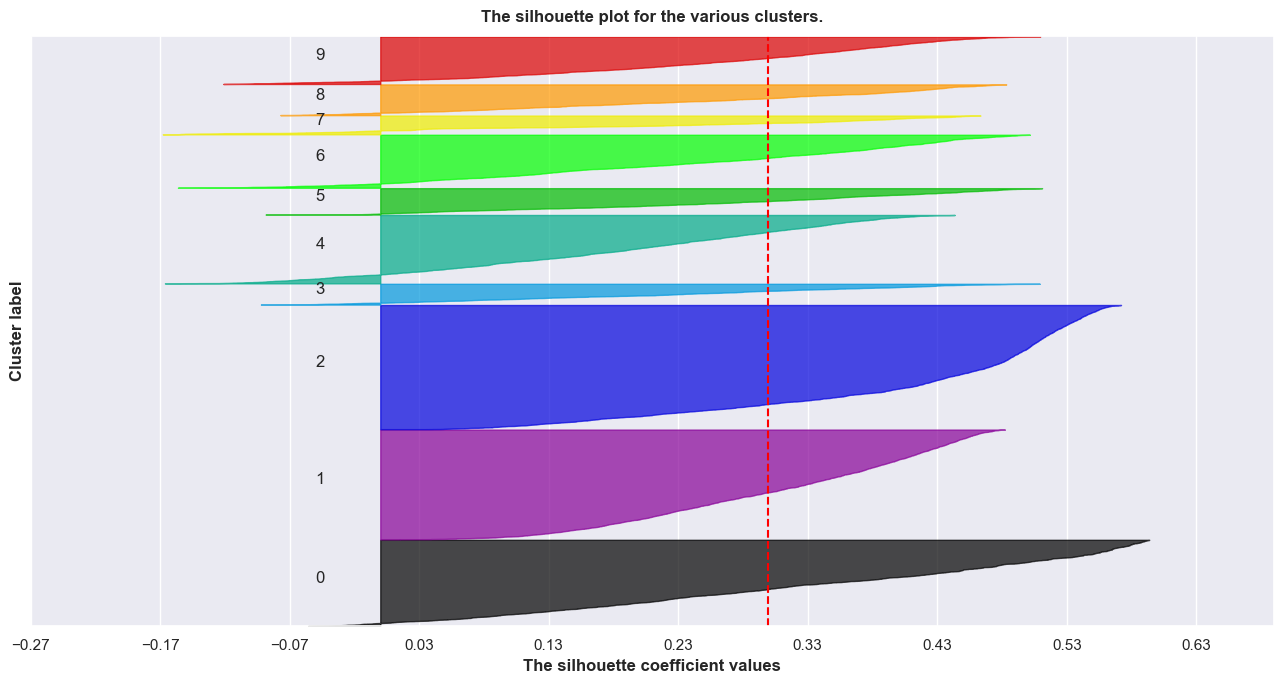

In [129]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_demographic[demographic_perspective])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_demographic[demographic_perspective], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_demographic[demographic_perspective], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_demographic[demographic_perspective]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

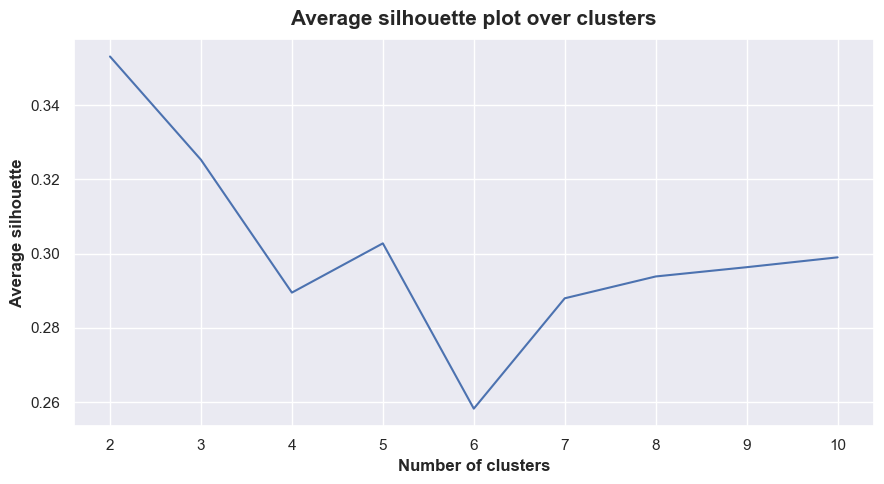

In [130]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

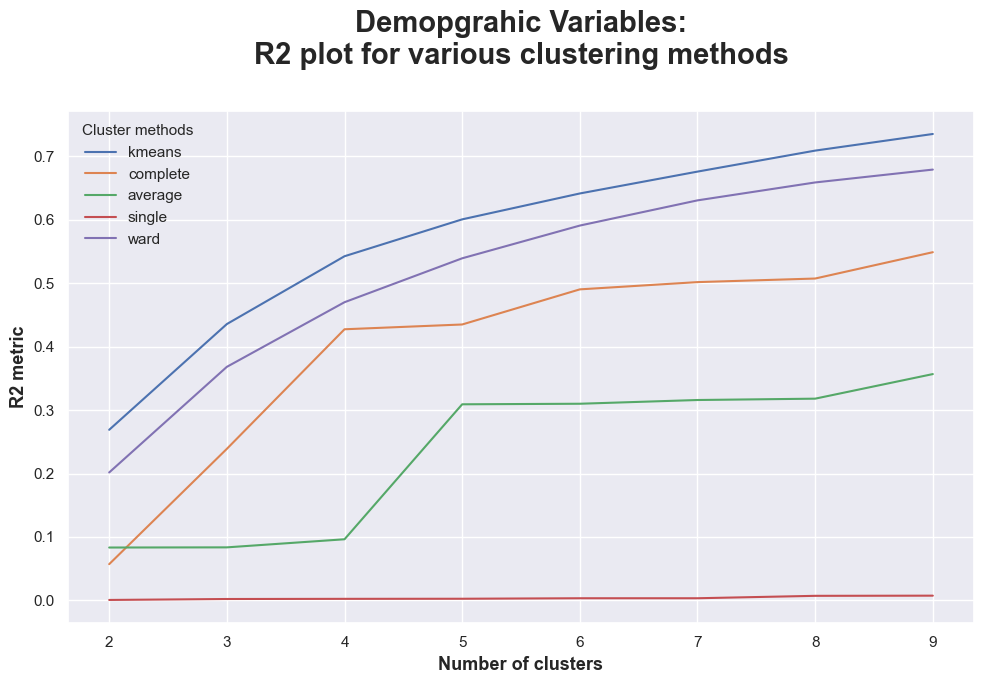

In [131]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_demographic, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_demographic, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demopgrahic Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

## Merging the Perspectives

In [106]:
df_frequency

PercentageOfVisits  PercentageOfClasses  Freq_Visits_Day  \
ID                                                                
10000                1.15             1.866571         0.763419   
10001               -0.20             0.104392        -0.204771   
10002                0.50             0.000000         1.208748   
10003                0.35             0.239981         0.463221   
10004               -0.50             0.000000        -0.255467   
...                   ...                  ...              ...   
24937                0.65             2.056875         0.190855   
24938               -0.25             0.000000         1.391650   
24939                0.85             0.000000         1.208748   
24940                1.70             2.010559         2.240557   
24941                0.55             0.014159         0.661034   

       Visits_ActivePeriod  
ID                          
10000            -0.201465  
10001            -0.501832  
10002             0.619048  
10003            -0.300366  
10004            -0.600733  
...                    ...  
24937             1.000000  
24938             0.007326  
24939             1.025641  
24940             0.802198  
24941             2.043956  

[14687 rows x 4 columns]

In [140]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=20,
    random_state=42
)
frequency_labels = kmeans_prod.fit_predict(df_frequency)

kmeans_behav = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
demographic_labels = kmeans_behav.fit_predict(df_demographic)

data['frequency_labels'] = frequency_labels
data['demographic_labels'] = demographic_labels

In [142]:
pd.crosstab(data['frequency_labels'],
            data['demographic_labels'])

demographic_labels     0     1     2
frequency_labels                    
0                   1109  4703  1258
1                    386   659   171
2                    591  1432   374
3                    136   404   204
4                    479  2156   625

#### Manual merging: Merge lowest frequency clusters into closest clusters

In [143]:
# Centroids of clusters
df_centroids = data.groupby(['frequency_labels', 'demographic_labels'])\
    [metric_features].mean()


# Clusters with low frequency to be merged:
# (behavior_labels, product_labels)
to_merge = [(3,0), (3,2), (1,0), (1,2), (3,1)]


# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(3, 0): (3, 2), (1, 0): (2, 0), (1, 2): (4, 2), (3, 1): (3, 2)}

In [144]:
df_ = data.copy()

# Changing the frequency_labels and demographic_labels based on source_target
for source, target in source_target.items():
    mask = (df_['frequency_labels']==source[0]) & (df_['frequency_labels']==source[1])
    df_.loc[mask, 'frequency_labels'] = target[0]
    df_.loc[mask, 'demographic_labels'] = target[1]

# New contigency table

pd.crosstab(df_['frequency_labels'],
            df_['demographic_labels'])

demographic_labels     0     1     2
frequency_labels                    
0                   1109  4703  1258
1                    386   659   171
2                    591  1432   374
3                    136   404   204
4                    479  2156   625

### Merging using Hierarchical clustering

In [145]:
# Centroids of the concatenated cluster labels
df_centroids = data.groupby(['frequency_labels', 'demographic_labels'])\
    [metric_features].mean()
df_centroids

Age  Contract_Duration  \
frequency_labels demographic_labels                                
0                0                   0.194545           1.706299   
                 1                  -0.044032          -0.153965   
                 2                   2.141892           0.189510   
1                0                  -0.891623           2.062667   
                 1                  -0.897825           0.031499   
                 2                   2.044347           0.416473   
2                0                  -0.672589           1.969176   
                 1                  -0.732542           0.063881   
                 2                   2.141934           0.348760   
3                0                   0.422794           2.098375   
                 1                   0.053630          -0.192742   
                 2                   2.526961           0.530296   
4                0                   0.295581           1.776761   
                 1                   0.031347          -0.185082   
                 2                   2.247600           0.265859   

                                     PercentageOfVisits  PercentageOfClasses  \
frequency_labels demographic_labels                                            
0                0                            -0.157439             0.041313   
                 1                            -0.202924             0.019628   
                 2                            -0.281916             0.030912   
1                0                             1.772280             2.080103   
                 1                             1.880425             2.072810   
                 2                             2.206433             2.105826   
2                0                            -0.046954             2.147680   
                 1                            -0.064455             2.181335   
                 2                            -0.192914             2.087669   
3                0                             1.912868             0.118810   
                 1                             1.837748             0.103966   
                 2                             1.769853             0.129038   
4                0                             0.673173             0.054595   
                 1                             0.576971             0.016865   
                 2                             0.564240             0.057066   

                                     Freq_Visits_Day  Visits_ActivePeriod  \
frequency_labels demographic_labels                                         
0                0                         -0.254643            -0.131462   
                 1                         -0.135021            -0.210254   
                 2                         -0.100638            -0.288958   
1                0                          0.055617             0.711078   
                 1                          0.316873             0.630120   
                 2                          0.513376             0.711887   
2                0                         -0.199312            -0.328015   
                 1                         -0.210547            -0.374486   
                 2                         -0.165377            -0.410462   
3                0                          1.627653             3.960138   
                 1                          2.669062             3.004289   
                 2                          2.177967             3.637183   
4                0                          0.650763             1.135875   
                 1                          0.993250             0.834918   
                 2                          1.115302             0.918476   

                                     MonthlyValue  Active_Period  
frequency_labels demographic_labels                               
0                0                      -0.728441       0.423416  
             

In [146]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

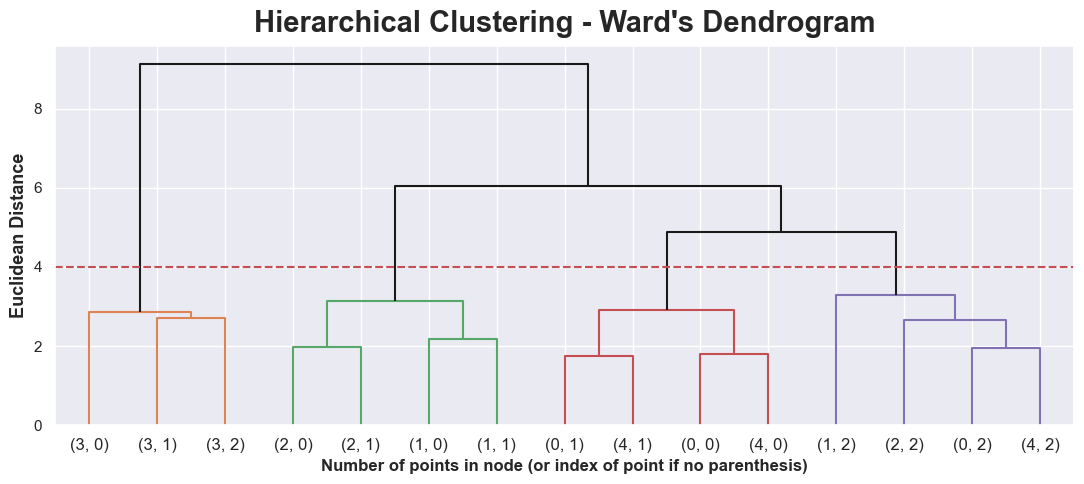

In [150]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [151]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Age  Contract_Duration  \
frequency_labels demographic_labels                                
0                0                   0.194545           1.706299   
                 1                  -0.044032          -0.153965   
                 2                   2.141892           0.189510   
1                0                  -0.891623           2.062667   
                 1                  -0.897825           0.031499   
                 2                   2.044347           0.416473   
2                0                  -0.672589           1.969176   
                 1                  -0.732542           0.063881   
                 2                   2.141934           0.348760   
3                0                   0.422794           2.098375   
                 1                   0.053630          -0.192742   
                 2                   2.526961           0.530296   
4                0                   0.295581           1.776761   
                 1                   0.031347          -0.185082   
                 2                   2.247600           0.265859   

                                     PercentageOfVisits  PercentageOfClasses  \
frequency_labels demographic_labels                                            
0                0                            -0.157439             0.041313   
                 1                            -0.202924             0.019628   
                 2                            -0.281916             0.030912   
1                0                             1.772280             2.080103   
                 1                             1.880425             2.072810   
                 2                             2.206433             2.105826   
2                0                            -0.046954             2.147680   
                 1                            -0.064455             2.181335   
                 2                            -0.192914             2.087669   
3                0                             1.912868             0.118810   
                 1                             1.837748             0.103966   
                 2                             1.769853             0.129038   
4                0                             0.673173             0.054595   
                 1                             0.576971             0.016865   
                 2                             0.564240             0.057066   

                                     Freq_Visits_Day  Visits_ActivePeriod  \
frequency_labels demographic_labels                                         
0                0                         -0.254643            -0.131462   
                 1                         -0.135021            -0.210254   
                 2                         -0.100638            -0.288958   
1                0                          0.055617             0.711078   
                 1                          0.316873             0.630120   
                 2                          0.513376             0.711887   
2                0                         -0.199312            -0.328015   
                 1                         -0.210547            -0.374486   
                 2                         -0.165377            -0.410462   
3                0                          1.627653             3.960138   
                 1                          2.669062             3.004289   
                 2                          2.177967             3.637183   
4                0                          0.650763             1.135875   
                 1                          0.993250             0.834918   
                 2                          1.115302             0.918476   

                                     MonthlyValue  Active_Period  \
frequency_labels demographic_labels                                
0                0                      -0.728441       0.423416   
          

In [152]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = data.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['frequency_labels'], row['demographic_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

Age  Contract_Duration  PercentageOfVisits  \
merged_labels                                                    
0              2.162239           0.249678            0.124856   
1              0.025788           0.191810            0.051788   
2             -0.776510           0.675426            0.587761   
3              0.799283           0.424317            1.832863   

               PercentageOfClasses  Freq_Visits_Day  Visits_ActivePeriod  \
merged_labels                                                              
0                         0.500592         0.245633             0.073624   
1                         0.023753         0.181811             0.143193   
2                         2.138804        -0.061607            -0.013167   
3                         0.113554         2.344042             3.352549   

               MonthlyValue  Active_Period  
merged_labels                               
0                  0.297947       0.409933  
1                 -0.087116       0.362411  
2                  0.355557       0.455520  
3                  0.408039       0.140821

In [153]:
df_

Age  UseByTime  AthleticsActivities  WaterActivities  \
ID                                                                 
10000  3.083333          0                  0.0              0.0   
10001  0.500000          0                  0.0              0.0   
10002  0.000000          0                  0.0              0.0   
10003 -1.166667          0                  0.0              0.0   
10004  1.000000          0                  0.0              0.0   
...         ...        ...                  ...              ...   
24937 -0.750000          0                  0.0              1.0   
24938  1.333333          0                  0.0              0.0   
24939 -0.250000          0                  0.0              0.0   
24940  2.666667          0                  0.0              1.0   
24941  0.750000          0                  0.0              0.0   

       FitnessActivities  TeamActivities  RacketActivities  CombatActivities  \
ID                                                                             
10000                1.0             0.0               0.0               0.0   
10001                0.0             0.0               0.0               0.0   
10002                1.0             0.0               0.0               0.0   
10003                0.0             1.0               0.0               0.0   
10004                1.0             0.0               0.0               0.0   
...                  ...             ...               ...               ...   
24937                0.0             0.0               0.0               0.0   
24938                0.0             0.0               0.0               1.0   
24939                1.0             0.0               0.0               0.0   
24940                0.0             0.0               0.0               0.0   
24941                1.0             0.0               0.0               0.0   

       SpecialActivities  OtherActivities  ...  Contract_Duration  \
ID                                         ...                      
10000                0.0              0.0  ...          -0.490868   
10001                1.0              0.0  ...           0.285388   
10002                0.0              0.0  ...          -0.554795   
10003                0.0              0.0  ...          -0.257991   
10004                0.0              0.0  ...           1.152968   
...                  ...              ...  ...                ...   
24937                0.0              0.0  ...           1.997717   
24938                0.0              0.0  ...          -0.027397   
24939                0.0              0.0  ...          -0.554795   
24940                0.0              0.0  ...           0.767123   
24941                0.0              0.0  ...           2.038813   

       PercentageOfVisits  MonthlyValue  PercentageOfClasses  Freq_Visits_Day  \
ID                                                                              
10000                1.15      3.017065             1.866571         0.763419   
10001               -0.20      0.607509             0.104392        -0.204771   
10002                0.50      0.493905             0.000000         1.208748   
10003                0.35      0.176012             0.239981         0.463221   
10004               -0.50     -0.611409             0.000000        -0.255467   
...                   ...           ...                  ...              ...   
24937                0.65      0.585080             2.056875         0.190855   
24938               -0.25      0.756216             0.000000         1.391650   
24939                0.85      0.786446             0.000000         1.208748   
24940                1.70      0.684544             2.010559         2.240557   
24941                0.55     -0.127743             0.014159         0.661034   

       Visits_ActivePeriod  Gender_Female  frequency_labels  \
ID                                                            
10000   

In [154]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['frequency_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['demographic_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts.pivot(values=0, index='frequency_labels', columns='demographic_labels')

demographic_labels       1       2
frequency_labels                  
2                   3068.0     NaN
3                      NaN   744.0
4                   8447.0  2428.0

In [155]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

### Profiling


findfont: Matching sans\-serif:style=normal:variant=normal:weight=heavy:stretch=normal:size=13.0.
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='c:\\Users\\afspf\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', s

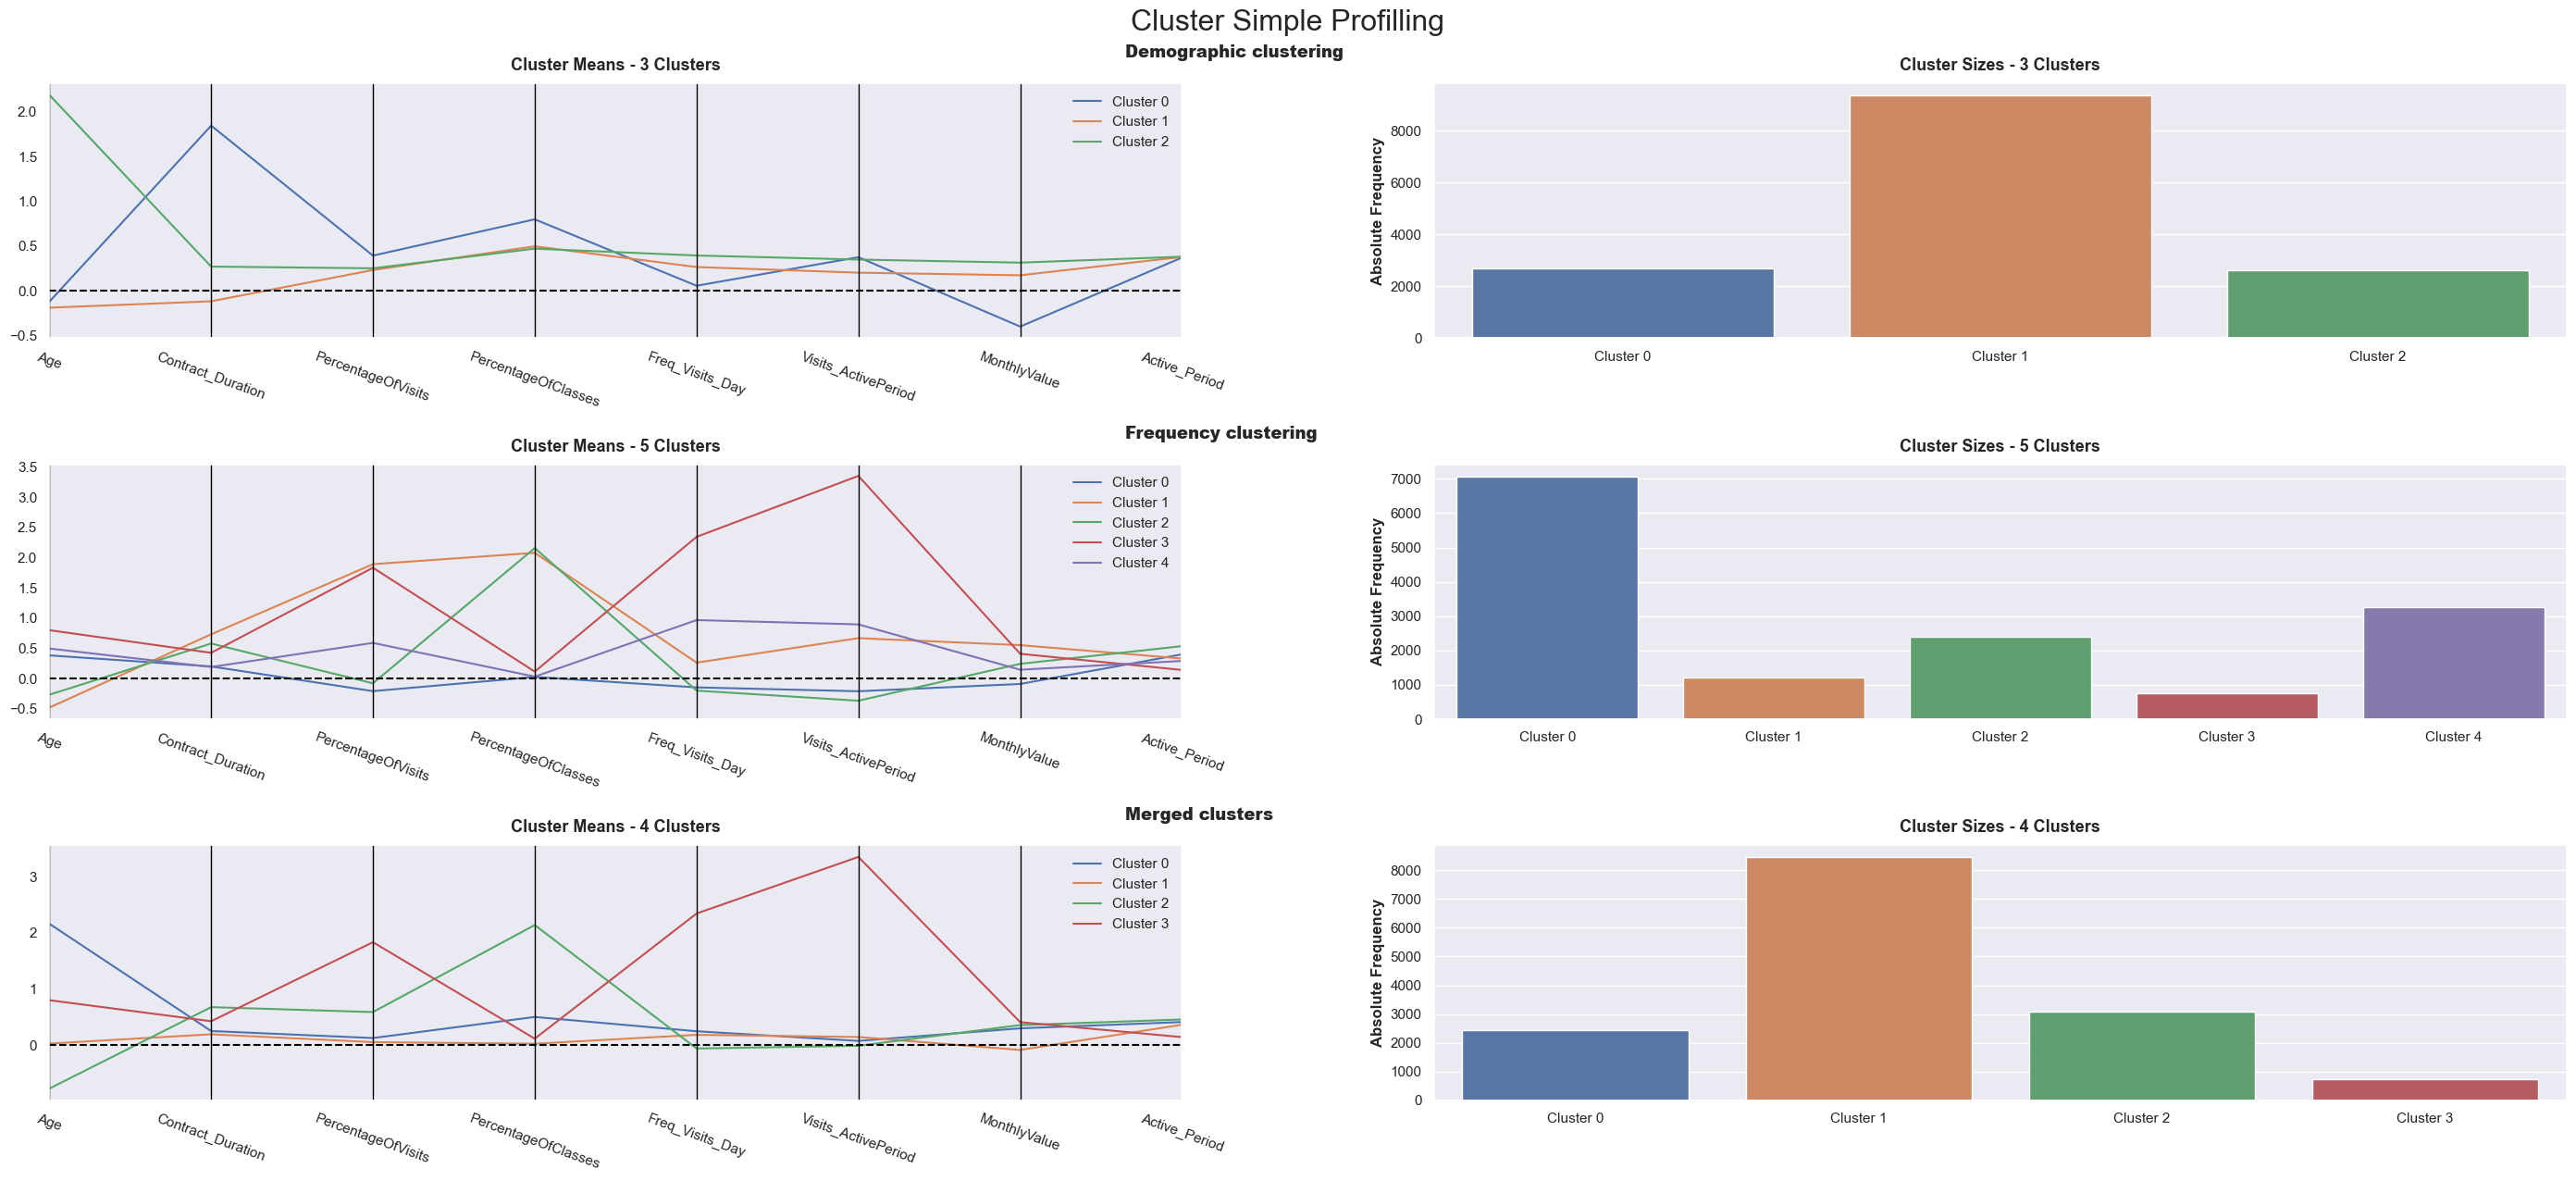

In [156]:

# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['demographic_labels', 'frequency_labels', 'merged_labels']], 
    label_columns = ['demographic_labels', 'frequency_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Demographic clustering", "Frequency clustering", "Merged clusters"]
)

In [157]:
sst = get_ss(df[metric_features])  
ssw_labels = df[metric_features+ ["merged_labels"]].groupby(by='merged_labels').apply(get_ss) 
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3810


In [158]:
df_study= df[["merged_labels"] + metric_features].groupby(["merged_labels"]).sum()

In [159]:
df_study[metric_features].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

In [161]:
df_study= df[["merged_labels"] + activities].groupby(["merged_labels"]).sum()

In [162]:
df_study[activities].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

In [163]:
df_study= df[["merged_labels"] + compare].groupby(["merged_labels"]).sum()

In [164]:
df_study[compare].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

### SOM + K-means clustering

### Frequency Perspective

In [ ]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']
compare = ['Dropout', 'Gender_Female','UseByTime']

In [17]:
frequency_perspective = [ 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']

In [18]:
np.random.seed(42)

sm_frequency = sompy.SOMFactory().build(
    data[frequency_perspective].values, 
    mapsize=[50, 50],  
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=frequency_perspective
)

sm_frequency.train(n_job=-1, verbose='info', train_rough_len=50, train_finetune_len=50)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 50

 epoch: 1 ---> elapsed time:  8.805000, quantization error: 0.686526

 epoch: 2 ---> elapsed time:  7.298000, quantization error: 1.710097

 epoch: 3 ---> elapsed time:  7.558000, quantization error: 1.680330

 epoch: 4 ---> elapsed time:  7.220000, quantization error: 1.674811

 epoch: 5 ---> elapsed time:  6.603000, quantization error: 1.671094

 epoch: 6 ---> elapsed time:  6.495000, quantization error: 1.667543

 epoch: 7 ---> elapsed time:  6.630000, quantization error: 1.655841

 epoch: 8 ---> elapsed time:  7.014000, quantization error: 1.652650

 epoch: 9 ---> elapsed time:  7.029000, quantization error: 1.649663

 epoch: 10 ---> elapsed time:  9.211000, quantization error: 1.646430

 epoch: 11 ---> elapsed time:  8.070000, quantization error: 1.642443

 epoch: 12 ---> elapsed time:  6.902000, quantization error: 1.637962

 epoch: 13 ---> 

In [19]:
range_clusters = range(2, 10)

inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=1)
    kmclust.fit(data[frequency_perspective])
    inertia.append(kmclust.inertia_)  

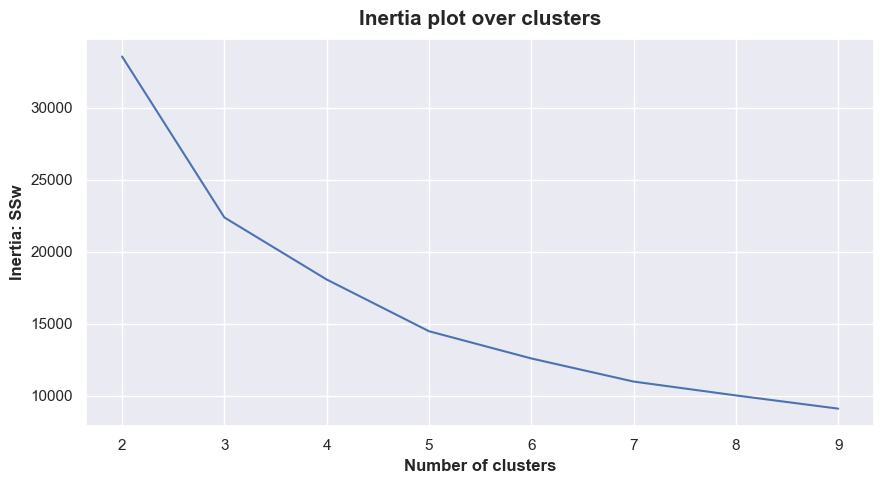

In [20]:
#perform inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

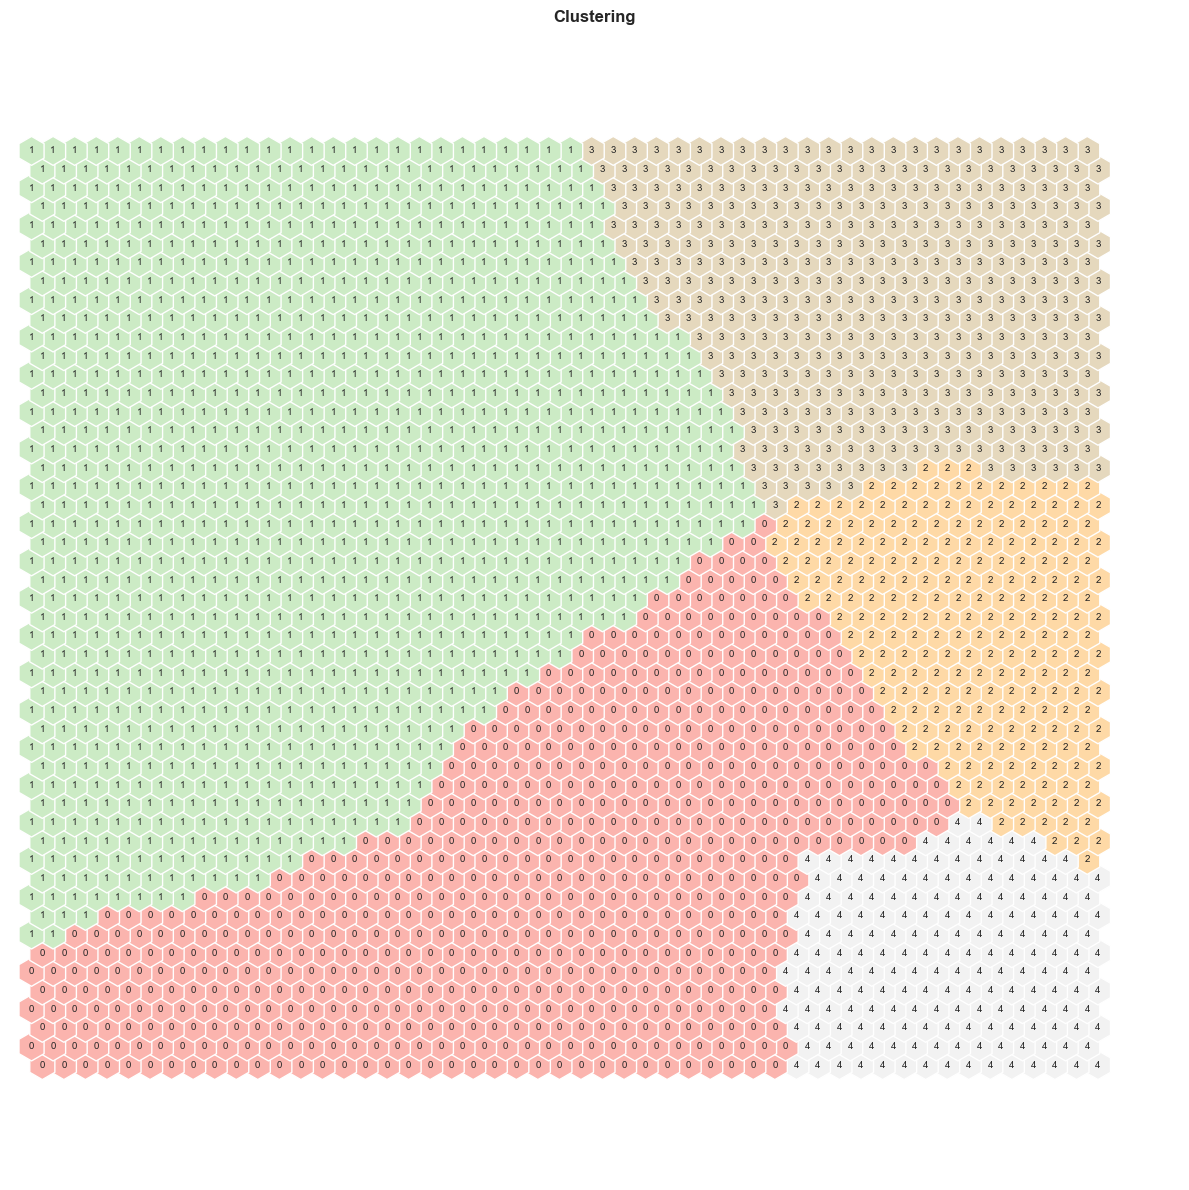

In [21]:
#performing K-Means clustering on top
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm_frequency.codebook.matrix)
sm_frequency.cluster_labels = nodeclus_labels 

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm_frequency, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

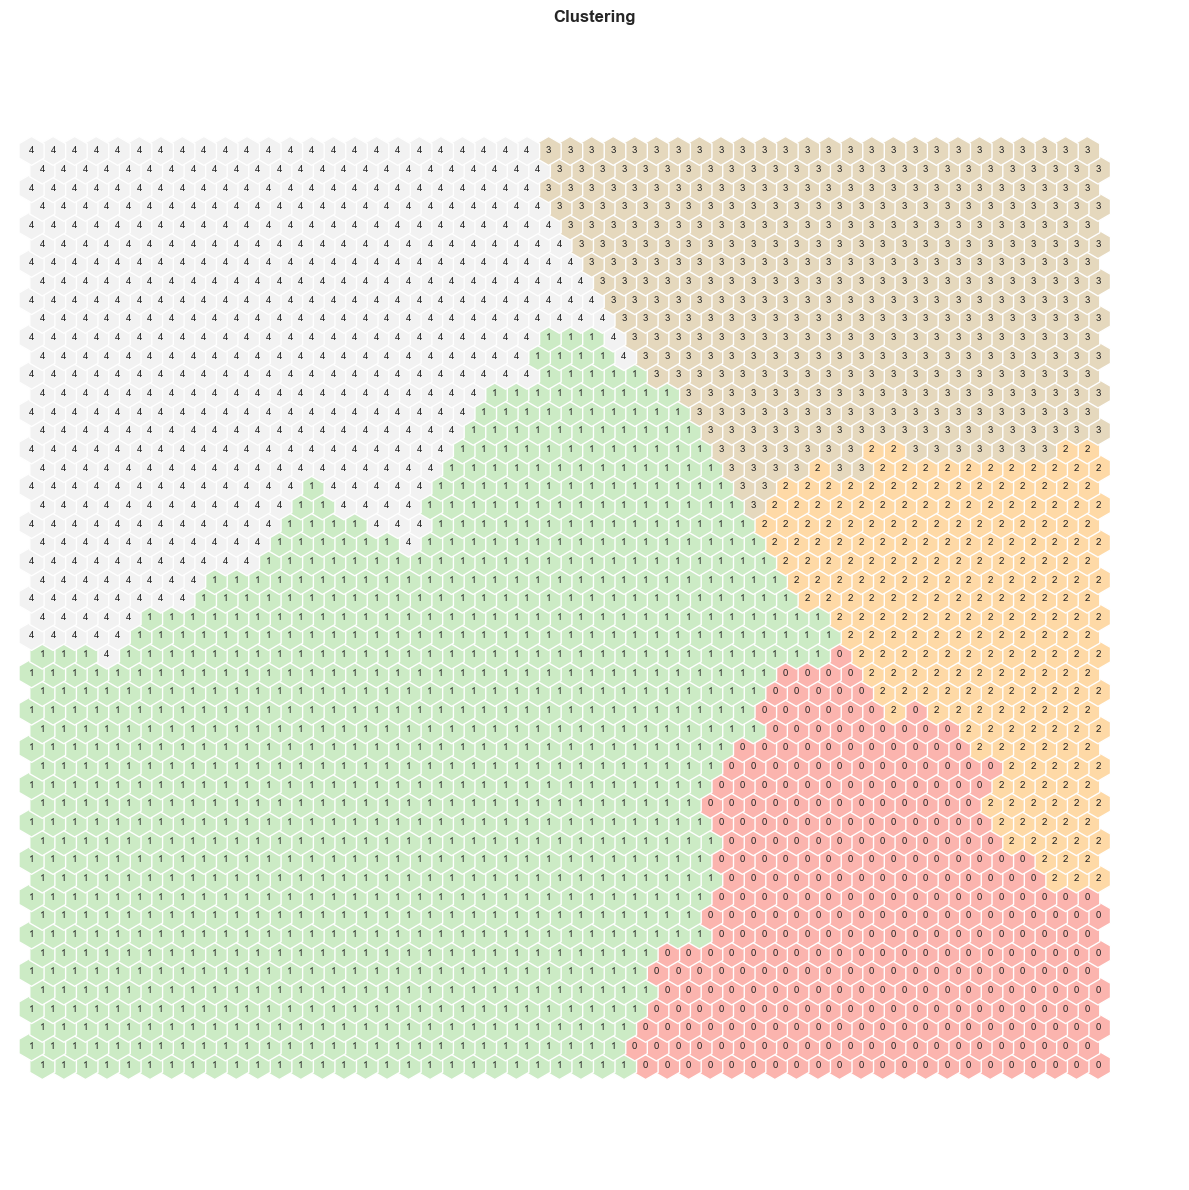

In [22]:
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm_frequency.codebook.matrix)
sm_frequency.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm_frequency, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [23]:
nodes = sm_frequency.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=frequency_perspective)
df_nodes['label_freq'] = nodeclus_labels
df_nodes

PercentageOfVisits  PercentageOfClasses  Freq_Visits_Day  \
0              -0.890385             2.031913        -1.001091   
1              -0.888510             1.981731        -0.940172   
2              -0.887275             1.946546        -0.862265   
3              -0.886516             1.942359        -0.771297   
4              -0.885969             1.954230        -0.670561   
...                  ...                  ...              ...   
2495           -0.086326            -0.570488         1.748237   
2496           -0.107861            -0.572247         1.982456   
2497           -0.126287            -0.567286         2.264069   
2498           -0.192139            -0.548988         2.654953   
2499           -0.304897            -0.563585         3.153803   

      Visits_ActivePeriod  label_freq  
0               -0.829927           3  
1               -0.828939           3  
2               -0.828343           3  
3               -0.827969           3  
4               -0.827660           3  
...                   ...         ...  
2495             0.064112           1  
2496             0.025556           1  
2497            -0.006695           1  
2498            -0.074511           1  
2499            -0.195371           1  

[2500 rows x 5 columns]

In [24]:
bmus_map = sm_frequency.find_bmu(data[frequency_perspective])[0] 
df_bmus_freq = pd.DataFrame(
    np.concatenate((data, np.expand_dims(bmus_map,1)), axis=1),
    index=data.index, columns=np.append(data.columns,"BMU_freq")
)
df_bmus_freq

Age  UseByTime  AthleticsActivities  WaterActivities  \
ID                                                                 
10000  3.083333        0.0                  0.0              0.0   
10001  0.500000        0.0                  0.0              0.0   
10002  0.000000        0.0                  0.0              0.0   
10003 -1.166667        0.0                  0.0              0.0   
10004  1.000000        0.0                  0.0              0.0   
...         ...        ...                  ...              ...   
24937 -0.750000        0.0                  0.0              1.0   
24938  1.333333        0.0                  0.0              0.0   
24939 -0.250000        0.0                  0.0              0.0   
24940  2.666667        0.0                  0.0              1.0   
24941  0.750000        0.0                  0.0              0.0   

       FitnessActivities  TeamActivities  RacketActivities  CombatActivities  \
ID                                                                             
10000                1.0             0.0               0.0               0.0   
10001                0.0             0.0               0.0               0.0   
10002                1.0             0.0               0.0               0.0   
10003                0.0             1.0               0.0               0.0   
10004                1.0             0.0               0.0               0.0   
...                  ...             ...               ...               ...   
24937                0.0             0.0               0.0               0.0   
24938                0.0             0.0               0.0               1.0   
24939                1.0             0.0               0.0               0.0   
24940                0.0             0.0               0.0               0.0   
24941                1.0             0.0               0.0               0.0   

       SpecialActivities  OtherActivities  Dropout  Active_Period  \
ID                                                                  
10000                0.0              0.0      0.0       0.000000   
10001                1.0              0.0      1.0       0.989071   
10002                0.0              0.0      1.0      -0.016393   
10003                0.0              0.0      1.0       0.989071   
10004                0.0              0.0      1.0      -0.016393   
...                  ...              ...      ...            ...   
24937                0.0              0.0      0.0       0.000000   
24938                0.0              0.0      1.0      -0.010929   
24939                0.0              0.0      1.0      -0.016393   
24940                0.0              0.0      0.0       0.000000   
24941                0.0              0.0      1.0      -0.016393   

       Contract_Duration  PercentageOfVisits  MonthlyValue  \
ID                                                           
10000          -0.490868                1.15      3.017065   
10001           0.285388               -0.20      0.607509   
10002          -0.554795                0.50      0.493905   
10003          -0.257991                0.35      0.176012   
10004           1.152968               -0.50     -0.611409   
...                  ...                 ...           ...   
24937           1.997717                0.65      0.585080   
24938          -0.027397               -0.25      0.756216   
24939          -0.554795                0.85      0.786446   
24940           0.767123                1.70      0.684544   
24941           2.038813                0.55     -0.127743   

       PercentageOfClasses  Freq_Visits_Day  Visits_ActivePeriod  \
ID                                                                 
10000             1.866571         0.763419            -0.201465   
10001             0.104392        -0.204771            -0.501832   
10002             0.000000         1.208748             0.619048   
10003             0.239981         0.4632

In [25]:
df_final = df_bmus_freq.merge(df_nodes['label_freq'], 'left', left_on="BMU_freq", right_index=True)
df_final

Age  UseByTime  AthleticsActivities  WaterActivities  \
ID                                                                 
10000  3.083333        0.0                  0.0              0.0   
10001  0.500000        0.0                  0.0              0.0   
10002  0.000000        0.0                  0.0              0.0   
10003 -1.166667        0.0                  0.0              0.0   
10004  1.000000        0.0                  0.0              0.0   
...         ...        ...                  ...              ...   
24937 -0.750000        0.0                  0.0              1.0   
24938  1.333333        0.0                  0.0              0.0   
24939 -0.250000        0.0                  0.0              0.0   
24940  2.666667        0.0                  0.0              1.0   
24941  0.750000        0.0                  0.0              0.0   

       FitnessActivities  TeamActivities  RacketActivities  CombatActivities  \
ID                                                                             
10000                1.0             0.0               0.0               0.0   
10001                0.0             0.0               0.0               0.0   
10002                1.0             0.0               0.0               0.0   
10003                0.0             1.0               0.0               0.0   
10004                1.0             0.0               0.0               0.0   
...                  ...             ...               ...               ...   
24937                0.0             0.0               0.0               0.0   
24938                0.0             0.0               0.0               1.0   
24939                1.0             0.0               0.0               0.0   
24940                0.0             0.0               0.0               0.0   
24941                1.0             0.0               0.0               0.0   

       SpecialActivities  OtherActivities  ...  Active_Period  \
ID                                         ...                  
10000                0.0              0.0  ...       0.000000   
10001                1.0              0.0  ...       0.989071   
10002                0.0              0.0  ...      -0.016393   
10003                0.0              0.0  ...       0.989071   
10004                0.0              0.0  ...      -0.016393   
...                  ...              ...  ...            ...   
24937                0.0              0.0  ...       0.000000   
24938                0.0              0.0  ...      -0.010929   
24939                0.0              0.0  ...      -0.016393   
24940                0.0              0.0  ...       0.000000   
24941                0.0              0.0  ...      -0.016393   

       Contract_Duration  PercentageOfVisits  MonthlyValue  \
ID                                                           
10000          -0.490868                1.15      3.017065   
10001           0.285388               -0.20      0.607509   
10002          -0.554795                0.50      0.493905   
10003          -0.257991                0.35      0.176012   
10004           1.152968               -0.50     -0.611409   
...                  ...                 ...           ...   
24937           1.997717                0.65      0.585080   
24938          -0.027397               -0.25      0.756216   
24939          -0.554795                0.85      0.786446   
24940           0.767123                1.70      0.684544   
24941           2.038813                0.55     -0.127743   

       PercentageOfClasses  Freq_Visits_Day  Visits_ActivePeriod  \
ID                                                                 
10000             1.866571         0.763419            -0.201465   
10001             0.104392        -0.204771            -0.501832   
10002             0.000000         1.208748             0.619048   
10003             0.239981         0.463221            -0.300366   
10004             0.00000

In [26]:
df_final.drop(columns='BMU_freq').groupby('label_freq').mean()

Age  UseByTime  AthleticsActivities  WaterActivities  \
label_freq                                                              
0           0.625120   0.071223             0.007410         0.157678   
1           0.422543   0.049279             0.006262         0.141029   
2          -0.449677   0.016270             0.002503         0.765332   
3           0.103061   0.035909             0.005660         0.356948   
4           0.429504   0.069243             0.017713         0.177670   

            FitnessActivities  TeamActivities  RacketActivities  \
label_freq                                                        
0                    0.814739        0.011527          0.001647   
1                    0.817043        0.016880          0.000817   
2                    0.102628        0.075094          0.081352   
3                    0.446916        0.103435          0.038642   
4                    0.589372        0.029522          0.005368   

            CombatActivities  SpecialActivities  OtherActivities   Dropout  \
label_freq                                                                   
0                   0.052285           0.055578         0.000412  0.745986   
1                   0.082222           0.022325         0.000272  0.880207   
2                   0.035670           0.025657         0.003129  0.450563   
3                   0.118267           0.020882         0.003708  0.894809   
4                   0.268921           0.003221         0.001074  0.935051   

            Active_Period  Contract_Duration  PercentageOfVisits  \
label_freq                                                         
0                0.227016           0.276071            1.134685   
1                0.332015           0.205351            0.092159   
2                0.326310           0.719381            1.668805   
3                0.496847           0.294118           -0.219584   
4                0.386858           0.286033           -0.391170   

            MonthlyValue  PercentageOfClasses  Freq_Visits_Day  \
label_freq                                                       
0               0.184335             0.019873         1.460872   
1              -0.021112             0.005138         0.457127   
2               0.524635             1.992755         0.229879   
3               0.142073             0.938861        -0.162329   
4              -0.297681             0.000064        -0.577533   

            Visits_ActivePeriod  Gender_Female  
label_freq                                      
0                      1.872492       0.548786  
1                      0.219325       0.611217  
2                      0.641250       0.573217  
3                     -0.329467       0.615340  
4                     -0.455276       0.613527

In [27]:
cluster_means = df_final.groupby('label_freq').mean()[frequency_perspective].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


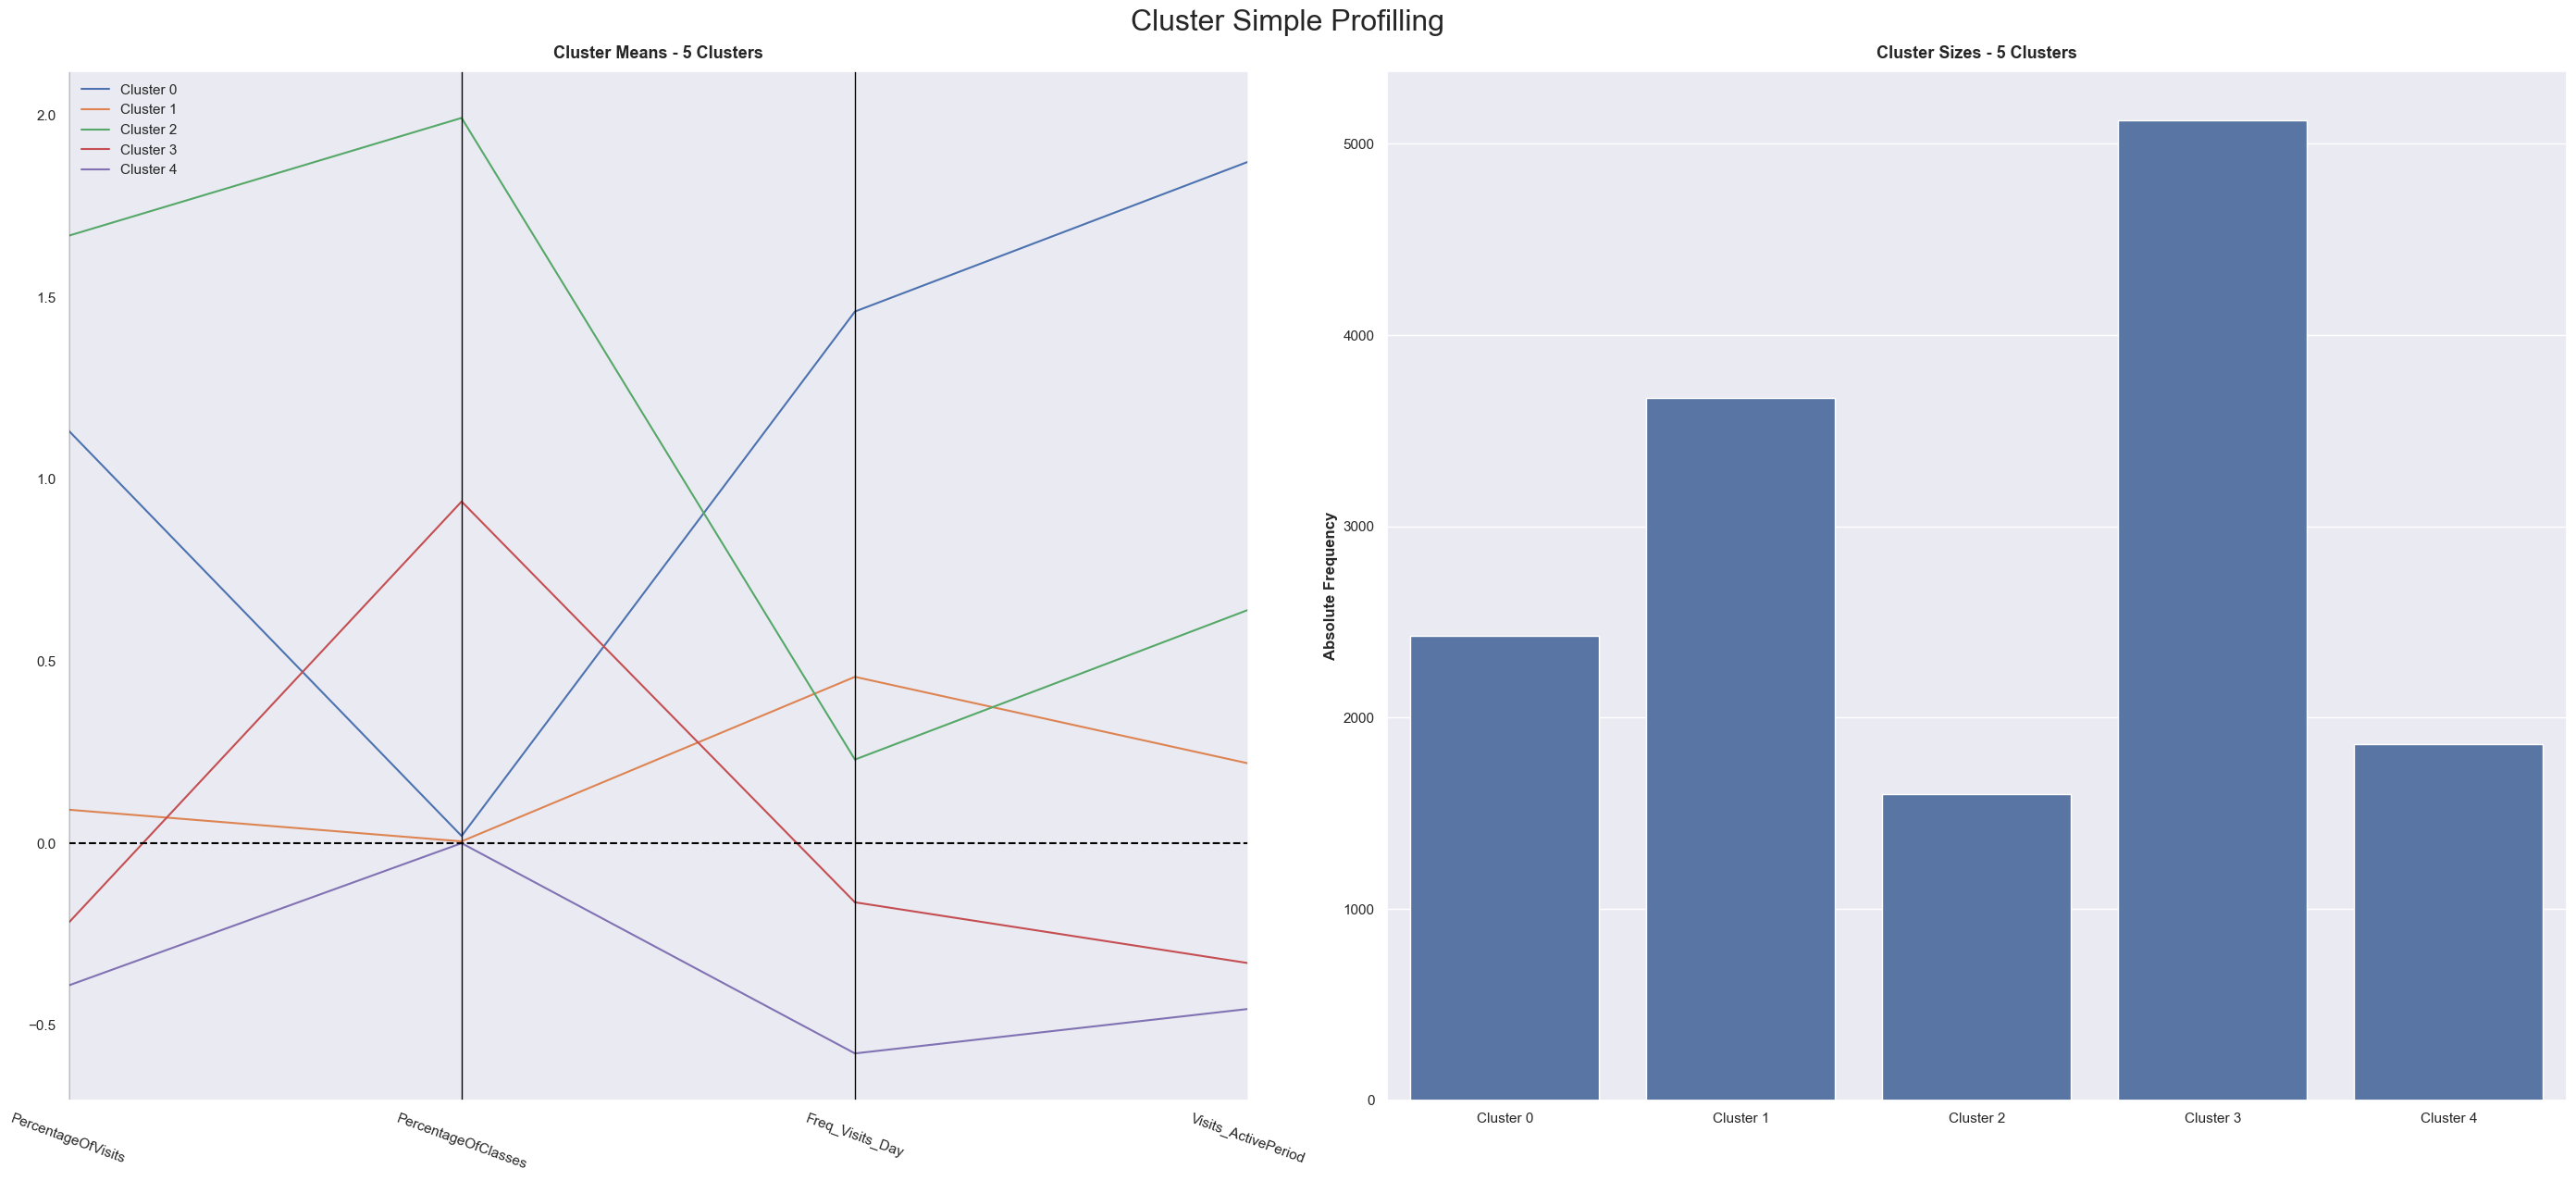

In [28]:
cluster_profiles(
    df = df_final[frequency_perspective + ["label_freq"]], 
    label_columns = ["label_freq"], 
    figsize = (28, 13), 
    compar_titles = [""]
)

### Demographic Perspective

In [29]:
demographic_perspective = ['Age', 'Active_Period', 'MonthlyValue', 'Contract_Duration']
df_demographic = data[demographic_perspective]

In [30]:
np.random.seed(42)

sm_demographic = sompy.SOMFactory().build(
    data[demographic_perspective].values, 
    mapsize=[50, 50], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=demographic_perspective
)

sm_demographic.train(n_job=-1, verbose='info', train_rough_len=50, train_finetune_len=50)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 50

 epoch: 1 ---> elapsed time:  7.372000, quantization error: 0.653477

 epoch: 2 ---> elapsed time:  7.764000, quantization error: 1.823122

 epoch: 3 ---> elapsed time:  7.081000, quantization error: 1.796397

 epoch: 4 ---> elapsed time:  7.248000, quantization error: 1.792374

 epoch: 5 ---> elapsed time:  7.474000, quantization error: 1.790255

 epoch: 6 ---> elapsed time:  7.133000, quantization error: 1.788063

 epoch: 7 ---> elapsed time:  7.285000, quantization error: 1.785411

 epoch: 8 ---> elapsed time:  6.850000, quantization error: 1.781950

 epoch: 9 ---> elapsed time:  7.003000, quantization error: 1.777600

 epoch: 10 ---> elapsed time:  6.395000, quantization error: 1.773093

 epoch: 11 ---> elapsed time:  7.450000, quantization error: 1.768965

 epoch: 12 ---> elapsed time:  7.557000, quantization error: 1.764819

 epoch: 13 ---> 

In [31]:
range_clusters = range(2, 10)

inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=1)
    kmclust.fit(data[demographic_perspective])
    inertia.append(kmclust.inertia_)  

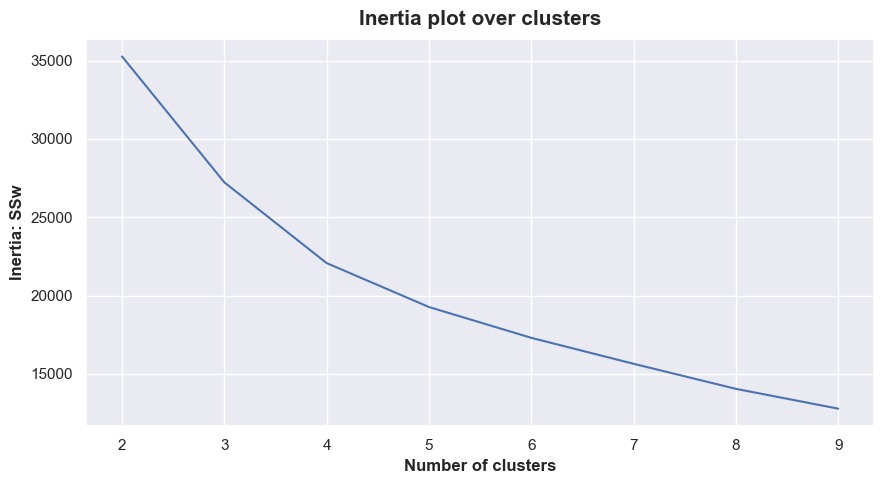

In [32]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

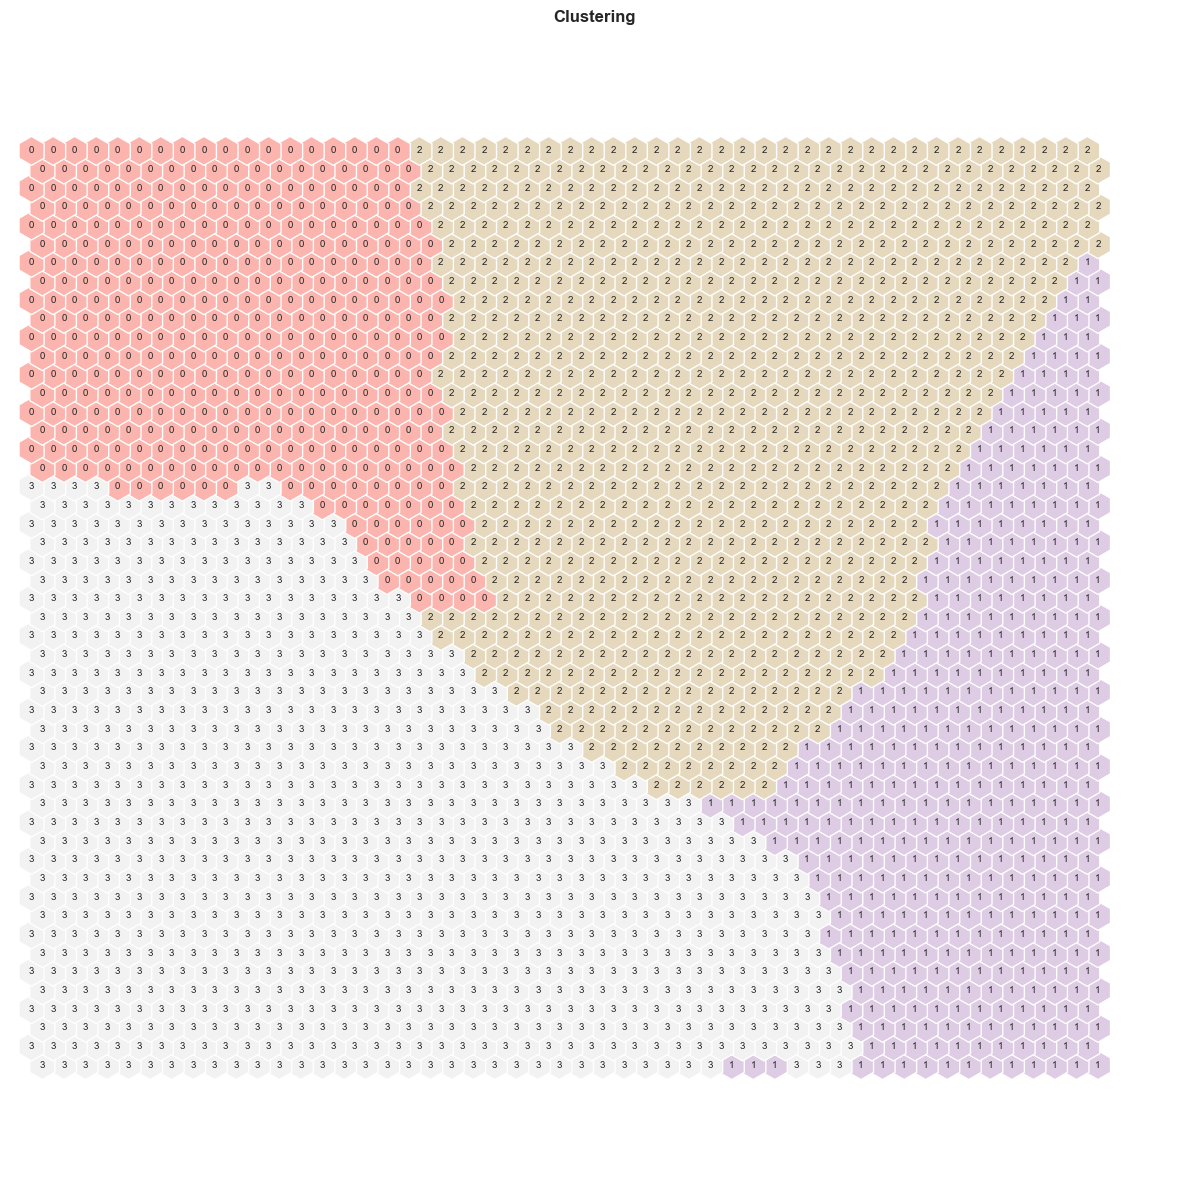

In [33]:
# Perform K-Means clustering on top of the 2500 units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm_demographic.codebook.matrix)
sm_demographic.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm_demographic, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

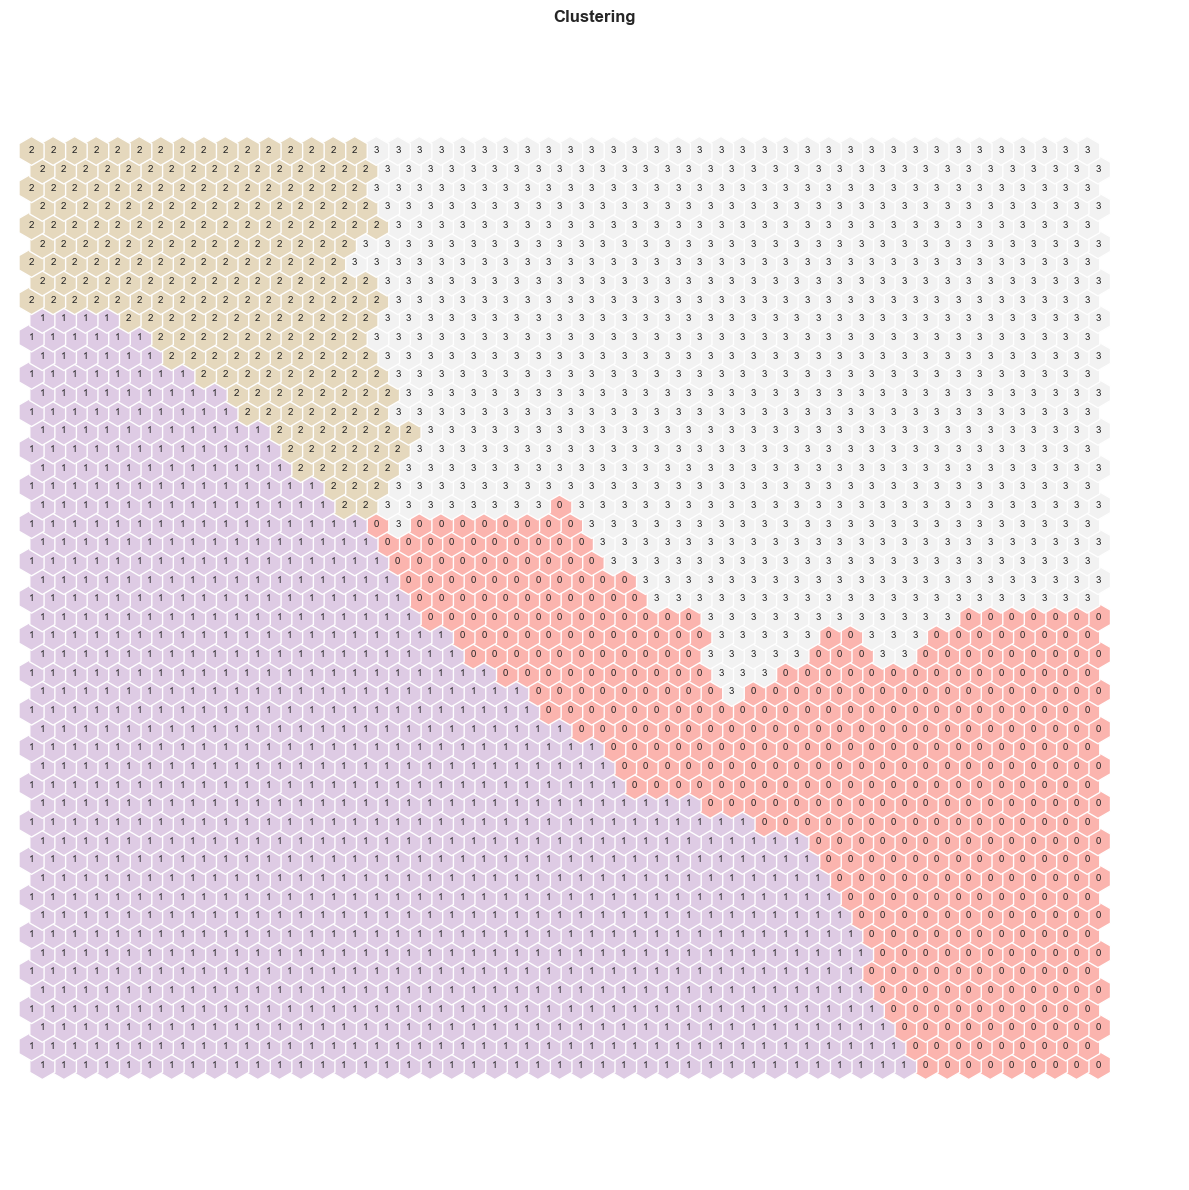

In [34]:
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm_demographic.codebook.matrix)
sm_demographic.cluster_labels = nodeclus_labels  

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm_demographic, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [35]:
nodes = sm_demographic.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=demographic_perspective)
df_nodes['label_demographic'] = nodeclus_labels
df_nodes

Age  Active_Period  MonthlyValue  Contract_Duration  \
0    -1.618947      -0.728054      0.528095           0.107113   
1    -1.611003      -0.727551      0.399548          -0.013664   
2    -1.600800      -0.728641      0.258732          -0.175332   
3    -1.575856      -0.727851      0.112946          -0.303542   
4    -1.499738      -0.728316     -0.015022          -0.155163   
...        ...            ...           ...                ...   
2495 -0.908978       1.170259      0.888292          -0.349172   
2496 -1.047935       1.169110      0.787236          -0.258351   
2497 -1.272191       1.168262      0.716365          -0.271780   
2498 -1.466914       1.167794      0.705434          -0.304239   
2499 -1.576577       1.167503      0.772965          -0.303014   

      label_demographic  
0                     3  
1                     3  
2                     3  
3                     3  
4                     3  
...                 ...  
2495                  1  
2496                  1  
2497                  1  
2498                  1  
2499                  1  

[2500 rows x 5 columns]

In [36]:
bmus_map = sm_demographic.find_bmu(data[demographic_perspective])[0] 
df_bmus_demographic = pd.DataFrame(
    np.concatenate((df_final, np.expand_dims(bmus_map,1)), axis=1),
    index=data.index, columns=np.append(df_final.columns,"BMU_demographic")
)
df_bmus_demographic

Age  UseByTime  AthleticsActivities  WaterActivities  \
ID                                                                 
10000  3.083333        0.0                  0.0              0.0   
10001  0.500000        0.0                  0.0              0.0   
10002  0.000000        0.0                  0.0              0.0   
10003 -1.166667        0.0                  0.0              0.0   
10004  1.000000        0.0                  0.0              0.0   
...         ...        ...                  ...              ...   
24937 -0.750000        0.0                  0.0              1.0   
24938  1.333333        0.0                  0.0              0.0   
24939 -0.250000        0.0                  0.0              0.0   
24940  2.666667        0.0                  0.0              1.0   
24941  0.750000        0.0                  0.0              0.0   

       FitnessActivities  TeamActivities  RacketActivities  CombatActivities  \
ID                                                                             
10000                1.0             0.0               0.0               0.0   
10001                0.0             0.0               0.0               0.0   
10002                1.0             0.0               0.0               0.0   
10003                0.0             1.0               0.0               0.0   
10004                1.0             0.0               0.0               0.0   
...                  ...             ...               ...               ...   
24937                0.0             0.0               0.0               0.0   
24938                0.0             0.0               0.0               1.0   
24939                1.0             0.0               0.0               0.0   
24940                0.0             0.0               0.0               0.0   
24941                1.0             0.0               0.0               0.0   

       SpecialActivities  OtherActivities  ...  Contract_Duration  \
ID                                         ...                      
10000                0.0              0.0  ...          -0.490868   
10001                1.0              0.0  ...           0.285388   
10002                0.0              0.0  ...          -0.554795   
10003                0.0              0.0  ...          -0.257991   
10004                0.0              0.0  ...           1.152968   
...                  ...              ...  ...                ...   
24937                0.0              0.0  ...           1.997717   
24938                0.0              0.0  ...          -0.027397   
24939                0.0              0.0  ...          -0.554795   
24940                0.0              0.0  ...           0.767123   
24941                0.0              0.0  ...           2.038813   

       PercentageOfVisits  MonthlyValue  PercentageOfClasses  Freq_Visits_Day  \
ID                                                                              
10000                1.15      3.017065             1.866571         0.763419   
10001               -0.20      0.607509             0.104392        -0.204771   
10002                0.50      0.493905             0.000000         1.208748   
10003                0.35      0.176012             0.239981         0.463221   
10004               -0.50     -0.611409             0.000000        -0.255467   
...                   ...           ...                  ...              ...   
24937                0.65      0.585080             2.056875         0.190855   
24938               -0.25      0.756216             0.000000         1.391650   
24939                0.85      0.786446             0.000000         1.208748   
24940                1.70      0.684544             2.010559         2.240557   
24941                0.55     -0.127743             0.014159         0.661034   

       Visits_ActivePeriod  Gender_Female  BMU_freq  label_freq  \
ID                                                                


In [37]:
df_final = df_bmus_demographic.merge(df_nodes['label_demographic'], 'left', left_on="BMU_demographic", right_index=True)
df_final

Age  UseByTime  AthleticsActivities  WaterActivities  \
ID                                                                 
10000  3.083333        0.0                  0.0              0.0   
10001  0.500000        0.0                  0.0              0.0   
10002  0.000000        0.0                  0.0              0.0   
10003 -1.166667        0.0                  0.0              0.0   
10004  1.000000        0.0                  0.0              0.0   
...         ...        ...                  ...              ...   
24937 -0.750000        0.0                  0.0              1.0   
24938  1.333333        0.0                  0.0              0.0   
24939 -0.250000        0.0                  0.0              0.0   
24940  2.666667        0.0                  0.0              1.0   
24941  0.750000        0.0                  0.0              0.0   

       FitnessActivities  TeamActivities  RacketActivities  CombatActivities  \
ID                                                                             
10000                1.0             0.0               0.0               0.0   
10001                0.0             0.0               0.0               0.0   
10002                1.0             0.0               0.0               0.0   
10003                0.0             1.0               0.0               0.0   
10004                1.0             0.0               0.0               0.0   
...                  ...             ...               ...               ...   
24937                0.0             0.0               0.0               0.0   
24938                0.0             0.0               0.0               1.0   
24939                1.0             0.0               0.0               0.0   
24940                0.0             0.0               0.0               0.0   
24941                1.0             0.0               0.0               0.0   

       SpecialActivities  OtherActivities  ...  PercentageOfVisits  \
ID                                         ...                       
10000                0.0              0.0  ...                1.15   
10001                1.0              0.0  ...               -0.20   
10002                0.0              0.0  ...                0.50   
10003                0.0              0.0  ...                0.35   
10004                0.0              0.0  ...               -0.50   
...                  ...              ...  ...                 ...   
24937                0.0              0.0  ...                0.65   
24938                0.0              0.0  ...               -0.25   
24939                0.0              0.0  ...                0.85   
24940                0.0              0.0  ...                1.70   
24941                0.0              0.0  ...                0.55   

       MonthlyValue  PercentageOfClasses  Freq_Visits_Day  \
ID                                                          
10000      3.017065             1.866571         0.763419   
10001      0.607509             0.104392        -0.204771   
10002      0.493905             0.000000         1.208748   
10003      0.176012             0.239981         0.463221   
10004     -0.611409             0.000000        -0.255467   
...             ...                  ...              ...   
24937      0.585080             2.056875         0.190855   
24938      0.756216             0.000000         1.391650   
24939      0.786446             0.000000         1.208748   
24940      0.684544             2.010559         2.240557   
24941     -0.127743             0.014159         0.661034   

       Visits_ActivePeriod  Gender_Female  BMU_freq  label_freq  \
ID                                                                
10000            -0.201465            1.0     957.0         2.0   
10001            -0.501832            1.0     571.0         3.0   
10002             0.619048            0.0    2270.0         0.0   
10003            -0.300366            0.0     

In [38]:
df_final.drop(columns='BMU_demographic').groupby('label_demographic').mean()

Age  UseByTime  AthleticsActivities  WaterActivities  \
label_demographic                                                              
0                  1.215352   0.033262             0.007676         0.257996   
1                  0.234853   0.041392             0.006749         0.289292   
2                  0.516631   0.135730             0.011803         0.405579   
3                 -0.445910   0.022572             0.005774         0.260892   

                   FitnessActivities  TeamActivities  RacketActivities  \
label_demographic                                                        
0                           0.623881        0.036674          0.016205   
1                           0.537642        0.055339          0.038542   
2                           0.576180        0.074034          0.010193   
3                           0.632546        0.053018          0.008136   

                   CombatActivities  SpecialActivities  OtherActivities  ...  \
label_demographic                                                        ...   
0                          0.093817           0.059701         0.002132  ...   
1                          0.124475           0.018746         0.003299  ...   
2                          0.109979           0.048283         0.000000  ...   
3                          0.088714           0.004199         0.000262  ...   

                   Active_Period  Contract_Duration  PercentageOfVisits  \
label_demographic                                                         
0                       0.001216          -0.089174            0.384627   
1                       0.817418           0.143238            0.153487   
2                       0.074043           2.078837            0.447183   
3                      -0.008529          -0.001735            0.301457   

                   MonthlyValue  PercentageOfClasses  Freq_Visits_Day  \
label_demographic                                                       
0                      0.867954             0.417281         0.596250   
1                      0.107916             0.557869         0.284332   
2                     -0.417159             0.686147         0.081733   
3                     -0.156267             0.547254         0.063158   

                   Visits_ActivePeriod  Gender_Female     BMU_freq  label_freq  
label_demographic                                                               
0                             0.591704       0.608955  1431.964179    1.666951  
1                             0.001064       0.600630  1142.137522    2.185513  
2                             0.606746       0.526288  1171.352468    1.943670  
3                             0.345564       0.623622  1160.789764    1.991601  

[4 rows x 21 columns]

In [39]:
cluster_means = df_final.groupby('label_demographic').mean()[demographic_perspective].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


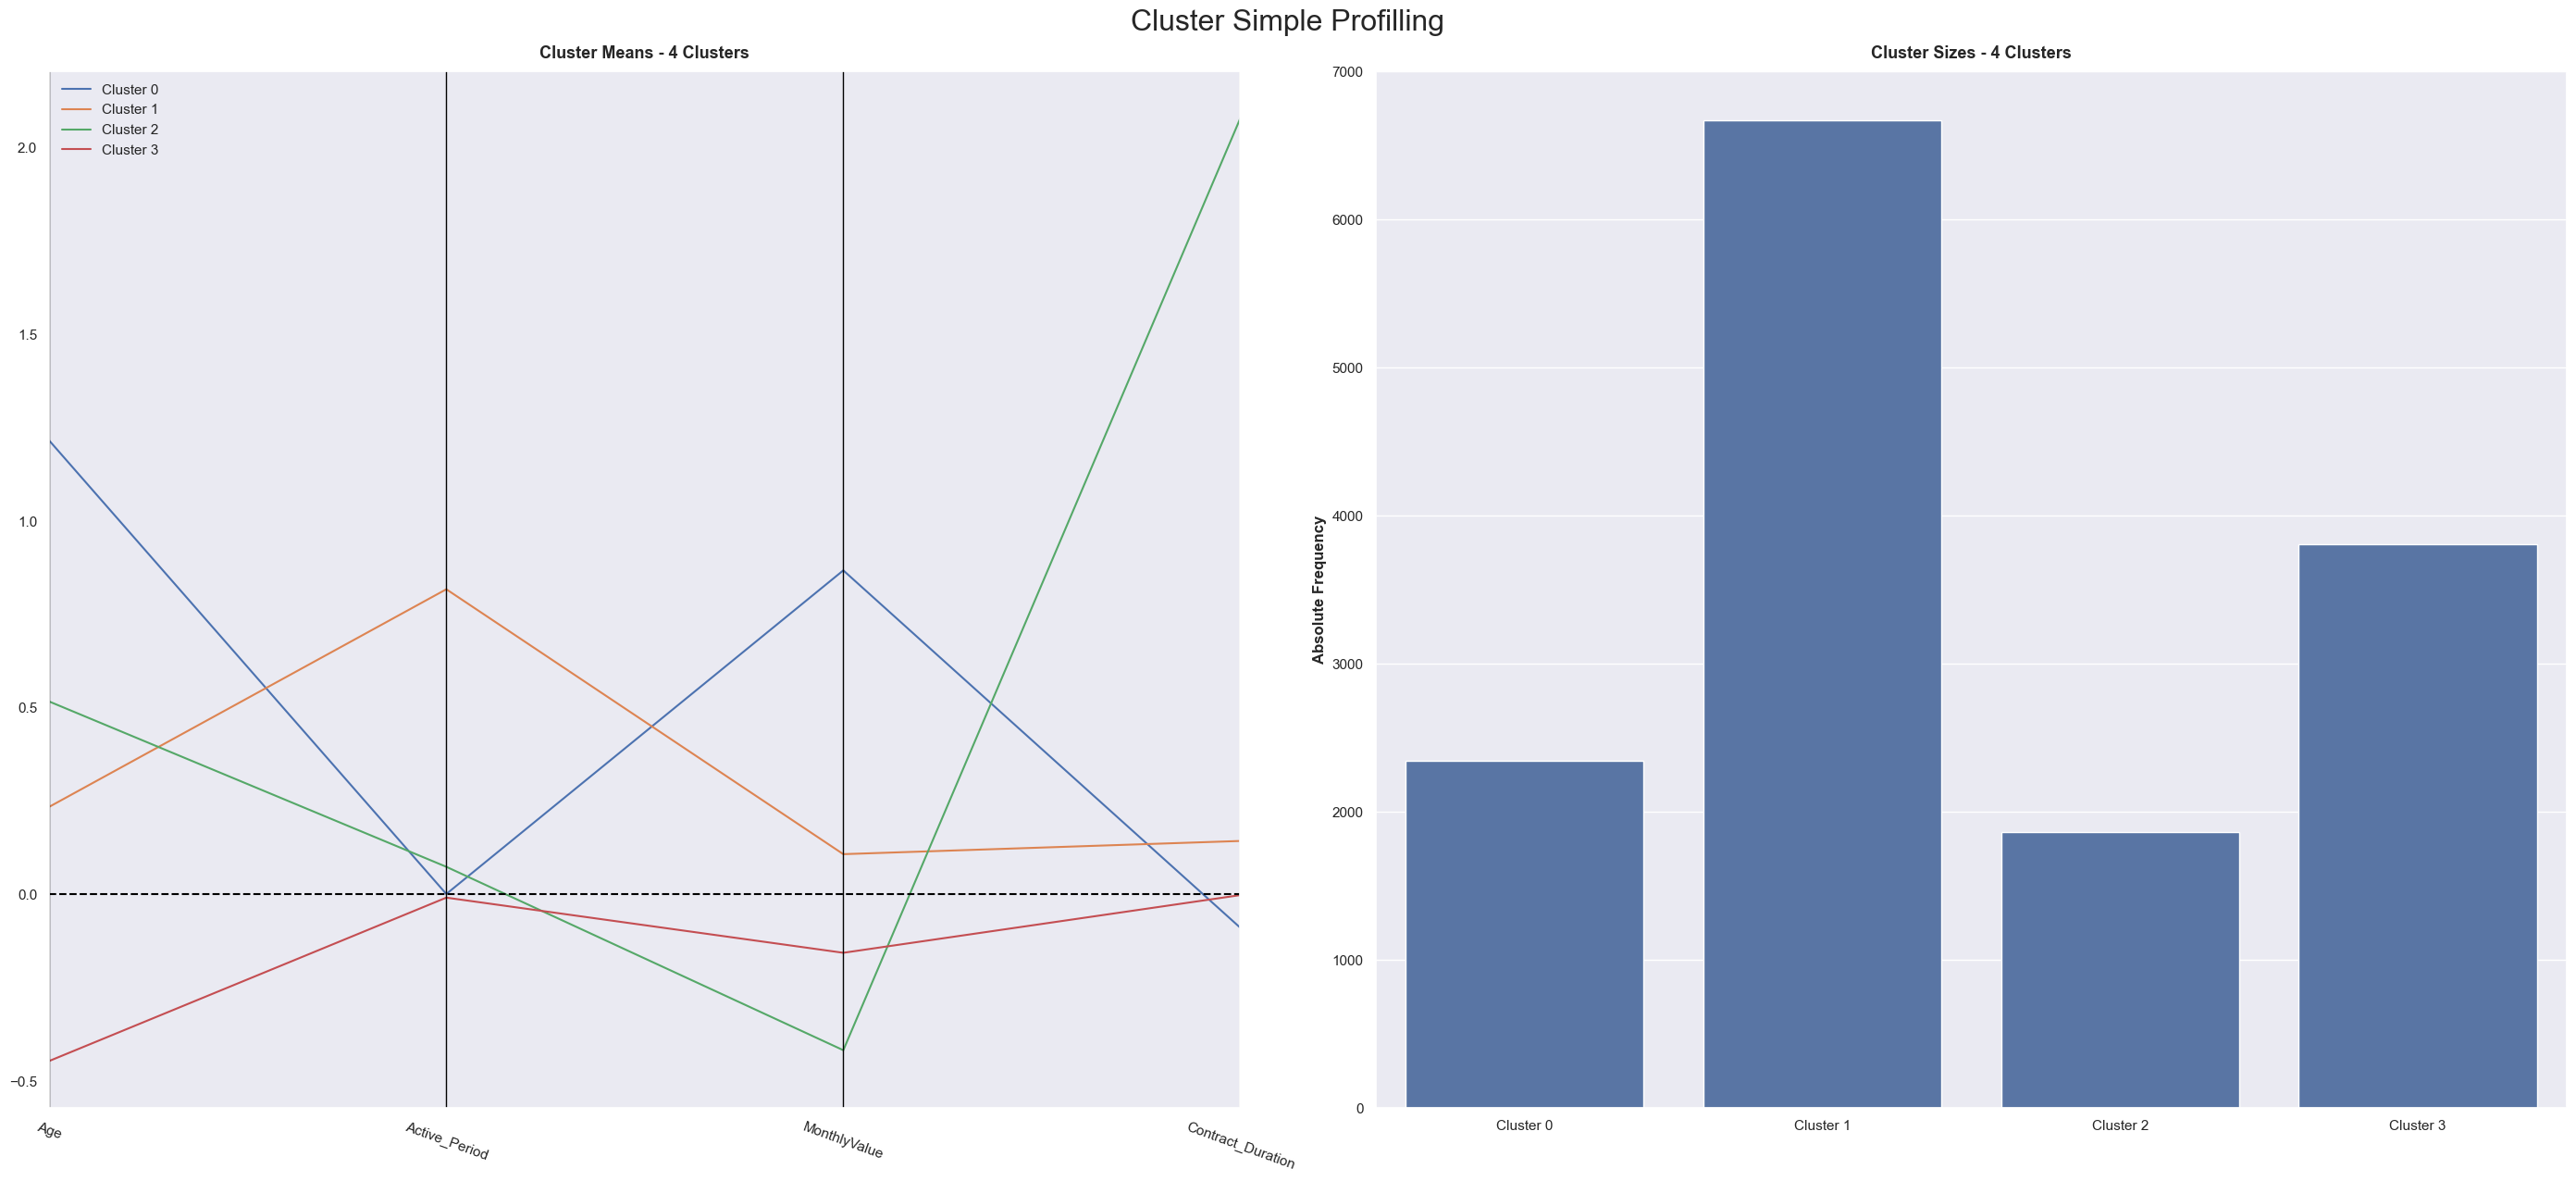

In [40]:
cluster_profiles(
    df = df_final[demographic_perspective + ["label_demographic"]], 
    label_columns = ["label_demographic"], 
    figsize = (28, 13), 
    compar_titles = [""]
)

### Merge Perspectives

In [41]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']

In [42]:
pd.crosstab(df_final['label_freq'],
            df_final['label_demographic'])

label_demographic    0     1    2     3
label_freq                             
0.0                623   889  343   574
1.0                625  1559  426  1063
2.0                242   522  338   496
3.0                620  2822  507  1175
4.0                235   876  250   502

In [43]:
df_centroids = df_final.groupby(['label_freq', 'label_demographic'])\
    [metric_features].mean()


# Clusters with low frequency to be merged:
to_merge = [(2,3), (2,2), (2,1), (3,3)]


# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(2, 3): (2.0, 1), (2, 2): (2.0, 1), (3, 3): (3.0, 1)}

In [44]:
df_ = df_final.copy()

for source, target in source_target.items():
    mask = (df_['label_freq']==source[0]) & (df_['label_demographic']==source[1])
    df_.loc[mask, 'label_freq'] = target[0]
    df_.loc[mask, 'label_demographic'] = target[1]


pd.crosstab(df_['label_freq'],
            df_['label_demographic'])

df = df_.copy()

## Merging using Hierarchical clustering:

In [45]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['label_demographic', 'label_freq'])\
    [metric_features].mean()
df_centroids

Age  Contract_Duration  PercentageOfVisits  \
label_demographic label_freq                                                    
0                 0.0         1.322632          -0.068097            1.148154   
                  1.0         1.249600          -0.052296            0.012800   
                  2.0         0.515840          -0.144751            1.773967   
                  3.0         1.249462          -0.136022           -0.242742   
                  4.0         1.470213          -0.062304           -0.426170   
1                 0.0         0.447600           0.027567            1.123678   
                  1.0         0.369735           0.053346            0.050353   
                  2.0        -0.621989           0.873599            1.650037   
                  3.0        -0.115941           0.131462           -0.218401   
                  4.0         0.471556           0.160362           -0.421290   
2                 0.0         1.094995           2.144787            1.189213   
                  1.0         0.845070           1.905862            0.140845   
                  3.0         0.427679           2.102447           -0.200592   
                  4.0         0.588667           1.795799           -0.349800   
3                 0.0        -0.137776          -0.082176            1.104530   
                  1.0        -0.155613          -0.101715            0.180621   
                  4.0        -0.210325          -0.083479           -0.342829   

                              PercentageOfClasses  Freq_Visits_Day  \
label_demographic label_freq                                         
0                 0.0                    0.030884         1.813185   
                  1.0                    0.006927         0.585212   
                  2.0                    1.955544         0.550417   
                  3.0                    0.776956        -0.162002   
                  4.0                    0.000000        -0.552870   
1                 0.0                    0.016176         1.762391   
                  1.0                    0.005062         0.678828   
                  2.0                    1.999396         0.172674   
                  3.0                    0.933660        -0.164970   
                  4.0                    0.000000        -0.564442   
2                 0.0                    0.023198         0.921338   
                  1.0                    0.008624         0.100204   
                  3.0                    1.177857        -0.141904   
                  4.0                    0.000480        -0.614398   
3                 0.0                    0.011662         0.933904   
                  1.0                    0.002802         0.199710   
                  4.0                    0.000000        -0.593564   

                              Visits_ActivePeriod  
label_demographic label_freq                       
0                 0.0                    2.132386  
                  1.0                    0.221128  
                  2.0                    0.856204  
                  3.0                   -0.275706  
                  4.0                   -0.491061  
1                 0.0                    1.459009  
                  1.0                    0.067353  
                  2.0                    0.602888  
                  3.0                   -0.343169  
                  4.0                   -0.514610  
2                 0.0                    2.625327  
                  1.0                    0.376387  
                  3.0                   -0.287188  
                  4.0                   -0.351502  
3                 0.0                    1.780941  
                  1.0                    0.378206  
                  4.0                   -0.386666

In [46]:
#use Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

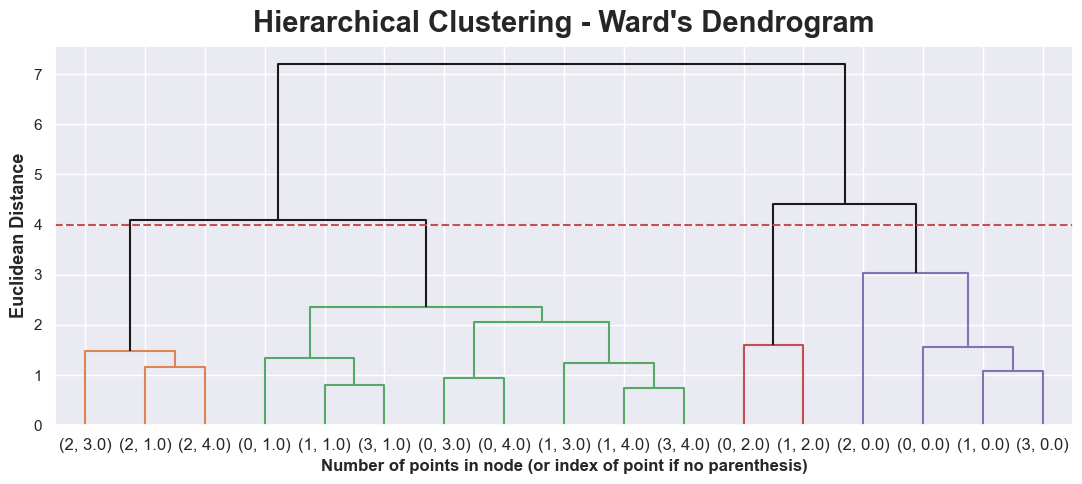

In [47]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 4
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [48]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids 

Age  Contract_Duration  PercentageOfVisits  \
label_demographic label_freq                                                    
0                 0.0         1.322632          -0.068097            1.148154   
                  1.0         1.249600          -0.052296            0.012800   
                  2.0         0.515840          -0.144751            1.773967   
                  3.0         1.249462          -0.136022           -0.242742   
                  4.0         1.470213          -0.062304           -0.426170   
1                 0.0         0.447600           0.027567            1.123678   
                  1.0         0.369735           0.053346            0.050353   
                  2.0        -0.621989           0.873599            1.650037   
                  3.0        -0.115941           0.131462           -0.218401   
                  4.0         0.471556           0.160362           -0.421290   
2                 0.0         1.094995           2.144787            1.189213   
                  1.0         0.845070           1.905862            0.140845   
                  3.0         0.427679           2.102447           -0.200592   
                  4.0         0.588667           1.795799           -0.349800   
3                 0.0        -0.137776          -0.082176            1.104530   
                  1.0        -0.155613          -0.101715            0.180621   
                  4.0        -0.210325          -0.083479           -0.342829   

                              PercentageOfClasses  Freq_Visits_Day  \
label_demographic label_freq                                         
0                 0.0                    0.030884         1.813185   
                  1.0                    0.006927         0.585212   
                  2.0                    1.955544         0.550417   
                  3.0                    0.776956        -0.162002   
                  4.0                    0.000000        -0.552870   
1                 0.0                    0.016176         1.762391   
                  1.0                    0.005062         0.678828   
                  2.0                    1.999396         0.172674   
                  3.0                    0.933660        -0.164970   
                  4.0                    0.000000        -0.564442   
2                 0.0                    0.023198         0.921338   
                  1.0                    0.008624         0.100204   
                  3.0                    1.177857        -0.141904   
                  4.0                    0.000480        -0.614398   
3                 0.0                    0.011662         0.933904   
                  1.0                    0.002802         0.199710   
                  4.0                    0.000000        -0.593564   

                              Visits_ActivePeriod  hclust_labels  
label_demographic label_freq                                      
0                 0.0                    2.132386              1  
                  1.0                    0.221128              0  
                  2.0                    0.856204              2  
                  3.0                   -0.275706              0  
                  4.0                   -0.491061              0  
1                 0.0                    1.459009              1  
                  1.0                    0.067353              0  
                  2.0                    0.602888              2  
                  3.0                   -0.343169              0  
                  4.0                   -0.514610              0  
2                 0.0                    2.625327              1  
                  1.0                    0.376387              0  
                  3.0                   -0.287188              0  
                  4.0                   -0.351502              0  
3                 0.0                    1.780941              1  
                  1.0    

In [49]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['label_demographic'], row['label_freq'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels')[metric_features].mean()

Age  Contract_Duration  PercentageOfVisits  \
merged_labels                                                    
0              0.270192           0.262120           -0.142158   
1              0.625120           0.276071            1.134685   
2             -0.449677           0.719381            1.668805   

               PercentageOfClasses  Freq_Visits_Day  Visits_ActivePeriod  
merged_labels                                                             
0                         0.453069        -0.021453            -0.162363  
1                         0.019873         1.460872             1.872492  
2                         1.992755         0.229879             0.641250

In [50]:
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['label_demographic'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['label_freq'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts.pivot(values=0, index='label_demographic', columns='label_freq')

label_freq            0.0     2.0      4.0
label_demographic                         
1                     NaN  1598.0      NaN
3                  2429.0     NaN  10660.0

In [51]:
df = df_.copy()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

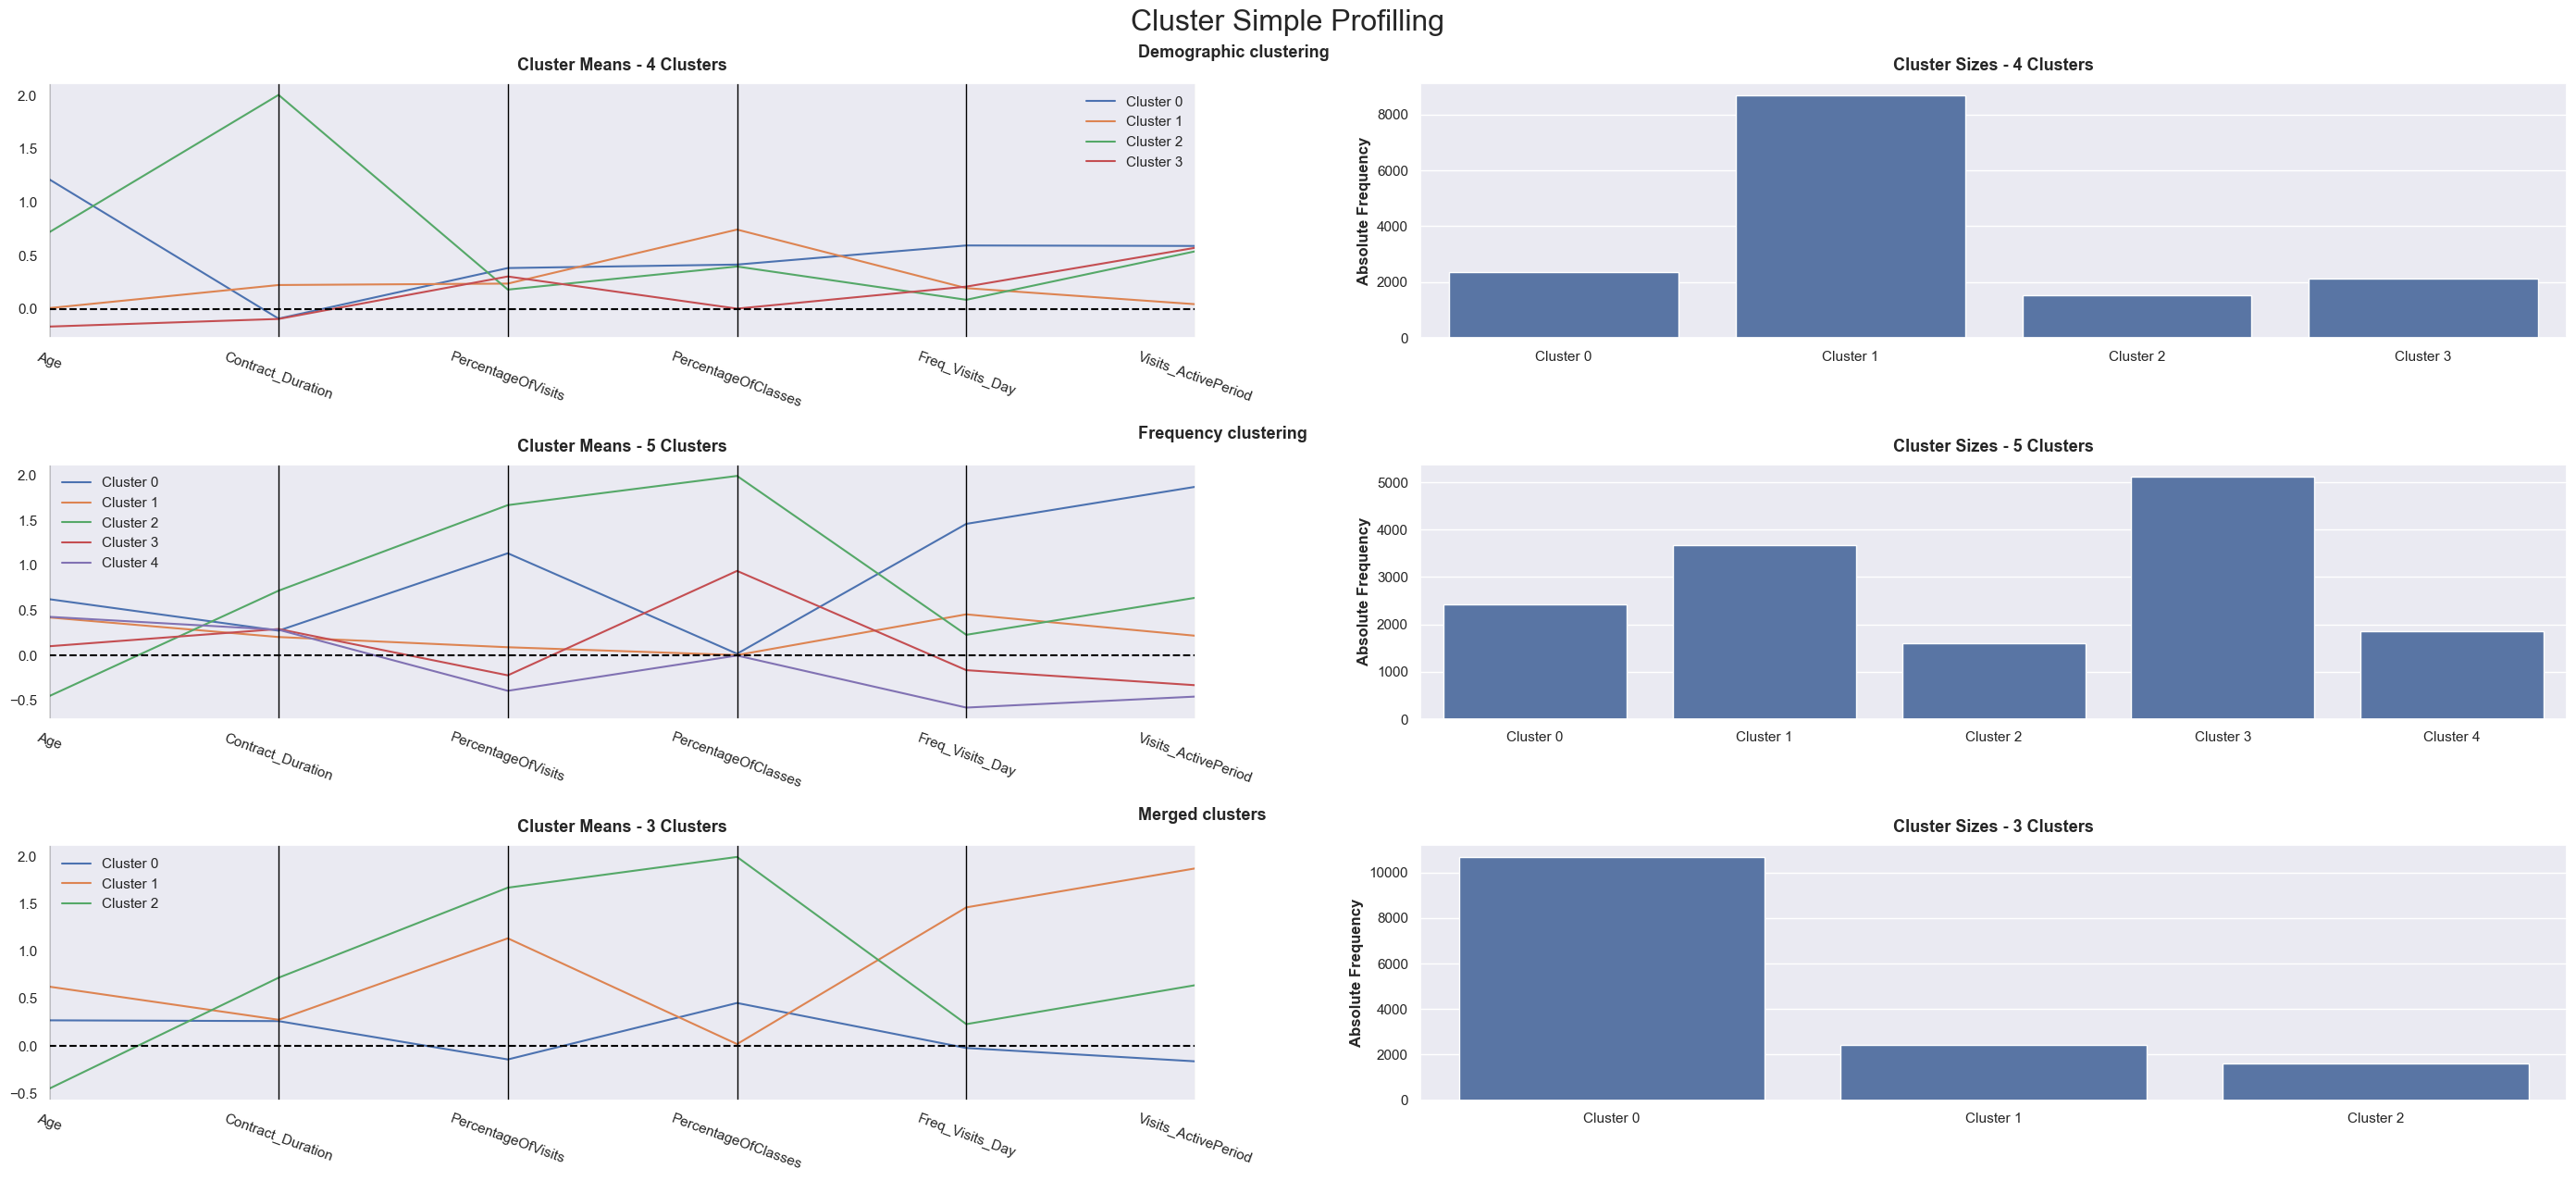

In [52]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['label_demographic', 'label_freq', 'merged_labels']], 
    label_columns = ['label_demographic', 'label_freq', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Demographic clustering", "Frequency clustering", "Merged clusters"])

In [53]:
sst = get_ss(df[metric_features])  
ssw_labels = df[metric_features+ ["merged_labels"]].groupby(by='merged_labels').apply(get_ss) 
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2974


In [54]:
df_study= df[["merged_labels"] + metric_features].groupby(["merged_labels"]).sum()

In [55]:
df_study[metric_features].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

In [56]:
df_study= df[["merged_labels"] + activities].groupby(["merged_labels"]).sum()

In [57]:
df_study[activities].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

In [58]:
df_study= df[["merged_labels"] + compare].groupby(["merged_labels"]).sum()

In [59]:
df_study[compare].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

## Gaussian Mixture Model:

#### Frequency studies:

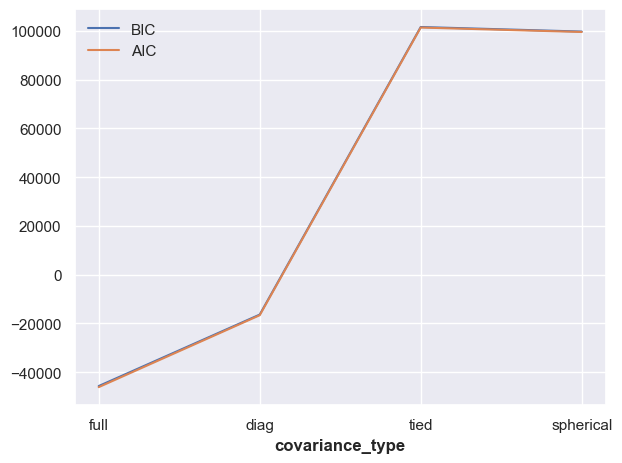

In [63]:
# Selecting covariance type based on AIC and BIC
cov_type = ['full','diag', 'tied', 'spherical']
models = [GaussianMixture(n_components=4, covariance_type=t, n_init=10, random_state=1).fit(df_frequency)
          for t in cov_type]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_frequency) for gmm in models]
aic_values = [gmm.aic(df_frequency) for gmm in models]
plt.plot(cov_type, bic_values, label='BIC')
plt.plot(cov_type, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('covariance_type')
plt.xticks(cov_type)
plt.show()

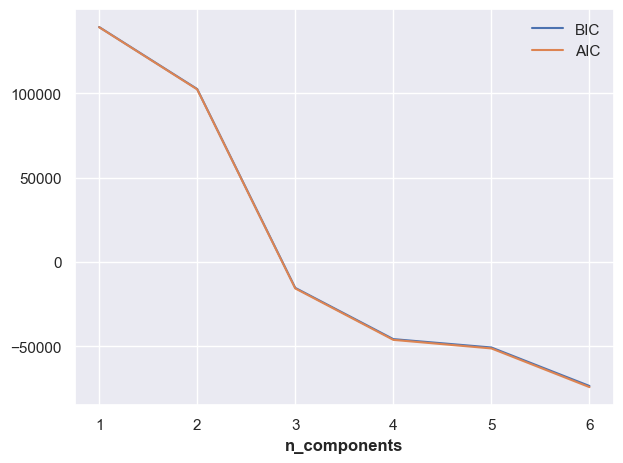

In [65]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_frequency)
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_frequency) for gmm in models]
aic_values = [gmm.aic(df_frequency) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [85]:
gmm = GaussianMixture(n_components=4, covariance_type='diag', n_init=10, init_params='k-means++', random_state=1, max_iter=3000, reg_covar=10**-3, tol = 10**-5)
freq_labels = gmm.fit_predict(df_frequency)
labels_proba = gmm.predict_proba(df_frequency)
freq_labels

array([1, 3, 2, ..., 2, 1, 2])

In [86]:
c= Counter(freq_labels)
c

Counter({3: 5683, 2: 3507, 1: 3044, 0: 2453})

In [89]:
counter = []
for n in range(0,4):
    counter.append(round(c[n]/df_frequency.shape[0],4))
counter

[0.167, 0.2073, 0.2388, 0.3869]

In [113]:
freq = pd.concat([data, pd.Series(freq_labels, index=data.index, name="freq_labels")], axis=1)

In [114]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(freq[frequency_perspective])  # get total sum of squares
ssw_labels = freq[frequency_perspective + ["freq_labels"]].groupby(by='freq_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.5001


### Demographic Prespective:

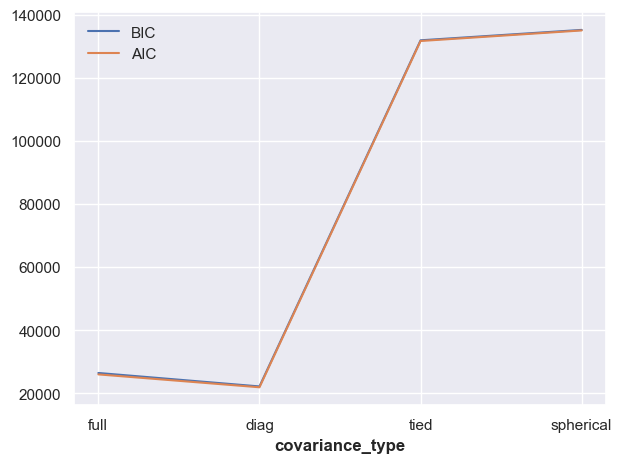

In [71]:
# Selecting covariance type based on AIC and BIC
cov_type = ['full','diag', 'tied', 'spherical']
models = [GaussianMixture(n_components=4, covariance_type=t, n_init=10, random_state=1).fit(df_demographic)
          for t in cov_type]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_demographic) for gmm in models]
aic_values = [gmm.aic(df_demographic) for gmm in models]
plt.plot(cov_type, bic_values, label='BIC')
plt.plot(cov_type, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('covariance_type')
plt.xticks(cov_type)
plt.show()

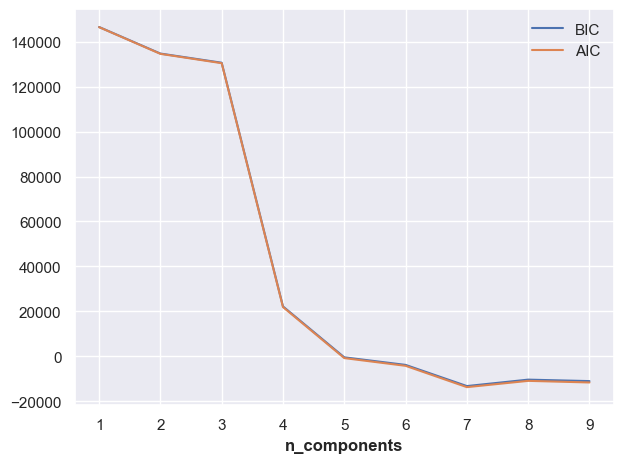

In [72]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='diag', n_init=10, random_state=1).fit(df_demographic)
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_demographic) for gmm in models]
aic_values = [gmm.aic(df_demographic) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [73]:
gmm = GaussianMixture(n_components=5, covariance_type='diag', n_init=10, init_params='k-means++', random_state=1, max_iter=3000, tol = 10**-4, reg_covar=10**-2)
dem_labels = gmm.fit_predict(df_demographic)
labels_proba = gmm.predict_proba(df_demographic)
dem_labels

array([0, 4, 0, ..., 0, 2, 2])

In [74]:
c= Counter(dem_labels)
c

Counter({4: 4798, 2: 3338, 0: 3005, 1: 2873, 3: 673})

In [75]:
counter = []
for n in range(0,5):
    counter.append(round(c[n]/df_demographic.shape[0],4))
counter

[0.2046, 0.1956, 0.2273, 0.0458, 0.3267]

In [76]:
dem = pd.concat([data, pd.Series(dem_labels, index=data.index, name="dem_labels")], axis=1)

In [77]:
sst = get_ss(dem[demographic_perspective])  # get total sum of squares
ssw_labels = dem[demographic_perspective+ ["dem_labels"]].groupby(by='dem_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3276


## Merging Prespectives:

In [115]:
data['freq_labels'] = freq_labels
data['dem_labels'] = dem_labels

In [116]:
pd.crosstab(data['freq_labels'],
            data['dem_labels'])

dem_labels      0     1     2    3     4
freq_labels                             
0             271   348   617  169  1048
1             576   139  1116  208  1005
2             907   943   817   96   744
3            1251  1443   788  200  2001

### Merging using Hierarchical clustering:

In [117]:
# Centroids of the concatenated cluster labels
df_centroids = data.groupby(['dem_labels', 'freq_labels'])\
    [metric_features].mean()
df_centroids

Age  Contract_Duration  PercentageOfVisits  \
dem_labels freq_labels                                                    
0          0            0.658672          -0.309887           -0.500000   
           1           -0.393953          -0.393962            0.959635   
           2            0.475928          -0.466536            0.881422   
           3            0.438916          -0.452613           -0.151719   
1          0           -0.085728           0.048536           -0.500000   
           1           -0.078537           0.076443            0.591727   
           2           -0.047367           0.027995            0.888706   
           3           -0.081543          -0.019056           -0.102322   
2          0            0.588736           1.107239           -0.500000   
           1           -0.498805           1.375610            1.099373   
           2            1.248980           1.382807            0.952326   
           3            1.019141           1.276586           -0.143909   
3          0            0.335306           1.701319           -0.498225   
           1           -0.325321           1.957982            0.581971   
           2            0.736111           2.185930            1.034375   
           3            0.667083           1.952283           -0.128500   
4          0            0.253340           0.120741           -0.500000   
           1           -0.121559           0.183219            0.847811   
           2            0.475806           0.012391            0.863172   
           3            0.315009          -0.040399           -0.190805   

                        PercentageOfClasses  Freq_Visits_Day  \
dem_labels freq_labels                                         
0          0                       0.583391        -0.372180   
           1                       1.900804         0.197359   
           2                       0.001881         1.701193   
           3                       0.000294         0.031734   
1          0                       0.415180        -0.393858   
           1                       1.668200        -0.014975   
           2                       0.001599         0.547288   
           3                       0.000262        -0.155306   
2          0                       1.135496        -0.335506   
           1                       1.939830         0.092733   
           2                       0.006922         0.959920   
           3                       0.002100        -0.061240   
3          0                       1.186893        -0.428988   
           1                       1.950461        -0.015126   
           2                       0.000587         1.059953   
           3                       0.002013        -0.093141   
4          0                       0.933702        -0.352395   
           1                       1.958986         0.206575   
           2                       0.001995         1.555518   
           3                       0.000421         0.151529   

                        Visits_ActivePeriod  
dem_labels freq_labels                       
0          0                      -0.600733  
           1                       0.383032  
           2                       1.426500  
           3                      -0.043177  
1          0                      -0.600733  
           1                       0.181833  
           2                       1.425553  
           3                       0.014358  
2          0                      -0.600733  
           1                       0.617443  
           2                       2.046516  
           3                      -0.001446  
3          0                      -0.598392  
           1                      -0.170541  
           2                       1.110539  
           3                      -0.196941  
4          0                      -0.600733  
           1                      -0.076493  
           2                       0.876738  
   

In [122]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

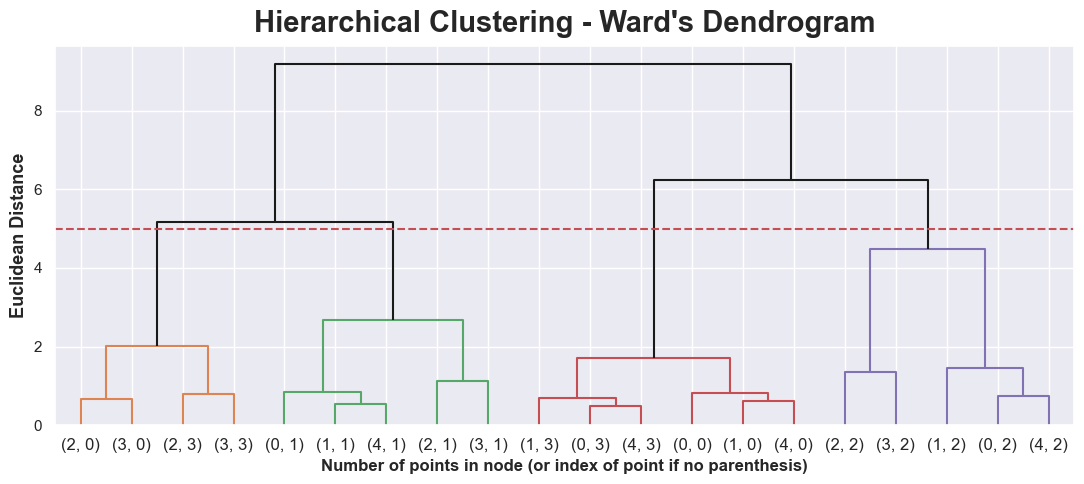

In [125]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 5
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [126]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Age  Contract_Duration  PercentageOfVisits  \
dem_labels freq_labels                                                    
0          0            0.658672          -0.309887           -0.500000   
           1           -0.393953          -0.393962            0.959635   
           2            0.475928          -0.466536            0.881422   
           3            0.438916          -0.452613           -0.151719   
1          0           -0.085728           0.048536           -0.500000   
           1           -0.078537           0.076443            0.591727   
           2           -0.047367           0.027995            0.888706   
           3           -0.081543          -0.019056           -0.102322   
2          0            0.588736           1.107239           -0.500000   
           1           -0.498805           1.375610            1.099373   
           2            1.248980           1.382807            0.952326   
           3            1.019141           1.276586           -0.143909   
3          0            0.335306           1.701319           -0.498225   
           1           -0.325321           1.957982            0.581971   
           2            0.736111           2.185930            1.034375   
           3            0.667083           1.952283           -0.128500   
4          0            0.253340           0.120741           -0.500000   
           1           -0.121559           0.183219            0.847811   
           2            0.475806           0.012391            0.863172   
           3            0.315009          -0.040399           -0.190805   

                        PercentageOfClasses  Freq_Visits_Day  \
dem_labels freq_labels                                         
0          0                       0.583391        -0.372180   
           1                       1.900804         0.197359   
           2                       0.001881         1.701193   
           3                       0.000294         0.031734   
1          0                       0.415180        -0.393858   
           1                       1.668200        -0.014975   
           2                       0.001599         0.547288   
           3                       0.000262        -0.155306   
2          0                       1.135496        -0.335506   
           1                       1.939830         0.092733   
           2                       0.006922         0.959920   
           3                       0.002100        -0.061240   
3          0                       1.186893        -0.428988   
           1                       1.950461        -0.015126   
           2                       0.000587         1.059953   
           3                       0.002013        -0.093141   
4          0                       0.933702        -0.352395   
           1                       1.958986         0.206575   
           2                       0.001995         1.555518   
           3                       0.000421         0.151529   

                        Visits_ActivePeriod  hclust_labels  
dem_labels freq_labels                                      
0          0                      -0.600733              2  
           1                       0.383032              1  
           2                       1.426500              0  
           3                      -0.043177              2  
1          0                      -0.600733              2  
           1                       0.181833              1  
           2                       1.425553              0  
           3                       0.014358              2  
2          0                      -0.600733              3  
           1                       0.617443              1  
           2                       2.046516              0  
           3                      -0.001446              3  
3          0                      -0.598392              3  
           1                      -0.170541           

In [127]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = data.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['dem_labels'], row['freq_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels')[metric_features].mean()

Age  Contract_Duration  PercentageOfVisits  \
merged_labels                                                    
0              0.522408           0.271478            0.900214   
1             -0.323368           0.627555            0.931340   
2              0.231989          -0.096685           -0.244066   
3              0.764609           1.334327           -0.299775   

               PercentageOfClasses  Freq_Visits_Day  Visits_ActivePeriod  
merged_labels                                                             
0                         0.002969         1.169772             1.445406  
1                         1.927093         0.137828             0.270243  
2                         0.201617        -0.076773            -0.241613  
3                         0.509156        -0.195260            -0.288787

In [128]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['dem_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['freq_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts.pivot(values=0, index='dem_labels', columns='freq_labels')

freq_labels       1       2       3
dem_labels                         
3               NaN     NaN  1774.0
4            3044.0  3507.0  6362.0

In [129]:
df = df_.copy()

## Profiling:

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

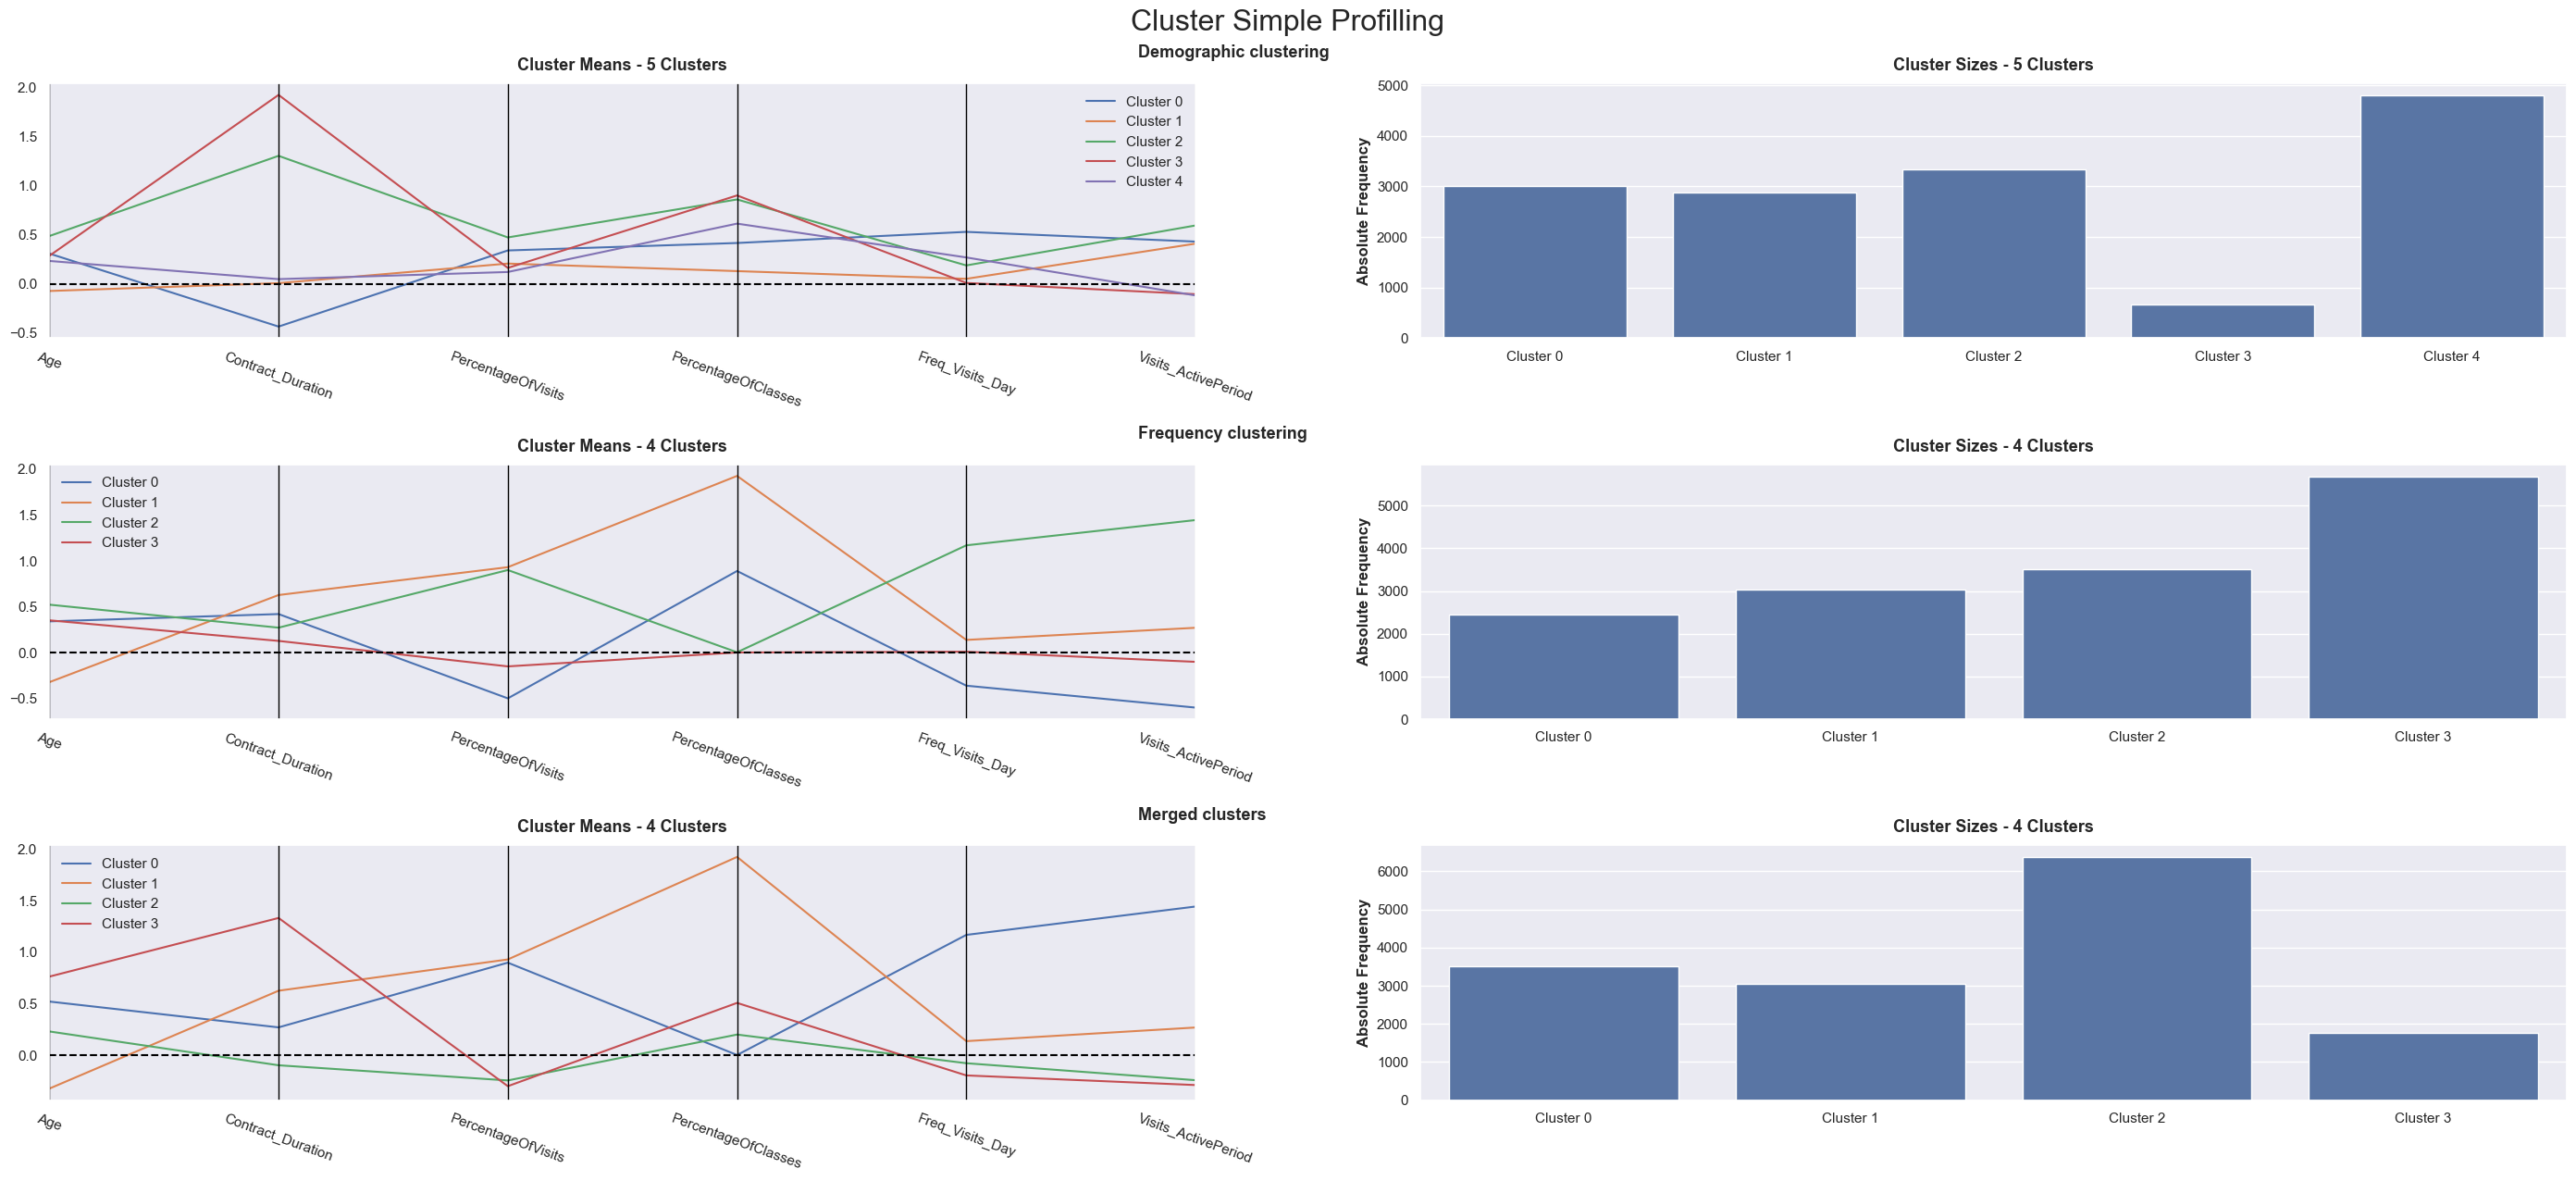

In [130]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['dem_labels', 'freq_labels', 'merged_labels']], 
    label_columns = ['dem_labels', 'freq_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Demographic clustering", "Frequency clustering", "Merged clusters"])

In [131]:
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df[metric_features+ ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3395


In [132]:
df_study= df[["merged_labels"] + metric_features].groupby(["merged_labels"]).sum()

In [133]:
df_study[metric_features].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

In [134]:
df_study= df[["merged_labels"] + activities].groupby(["merged_labels"]).sum()

In [135]:
df_study[activities].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)

In [136]:
df_study= df[["merged_labels"] + compare].groupby(["merged_labels"]).sum()

In [137]:
df_study[compare].apply(lambda col: col/(col.sum())).style.format(precision=2).background_gradient(axis=0)